**[Reproduction]**

**Title:** Modeling the rate of senescence: can estimated biological age predict mortality more accurately than chronological age?

**Short introduction:** In this article, the authors use the NHANES database to calculate biological age from blood data using various models (MLR, PCA, KDM)

**Main hypothesis:** Using 7 parameters from NHANES database, author of the paper shows that biological age computed by Klemera & Doubal method predicts mortality better than chronological age. 

**Project task/questions:**
1. Read the paper, prepare code for reproduction of the paper results (Hint: google the code)
2. Download NHANESIII data (from official website) or find a specific github repository where people already did it.
3. Reproduce all tables with results from the paper, your ultimate goal is to recompute hazard ratio for KDM-based biological age

**Data availability:** website https://wwwn.cdc.gov/nchs/nhanes/nhanes3/default.aspx, https://wwwn.cdc.gov/nchs/nhanes/nhanes3/datafiles.aspx

**Related paper:** link https://pubmed.ncbi.nlm.nih.gov/23213031/

**Team:** Marina Morozova

If you want to read and preprocess data yourself, use the following links to download raw data:
- lab.dat https://wwwn.cdc.gov/nchs/data/nhanes3/1a/lab.dat
- exam.dat https://wwwn.cdc.gov/nchs/data/nhanes3/1a/exam.dat
- adult.dat https://wwwn.cdc.gov/nchs/data/nhanes3/1a/adult.dat
- cmv.xpt https://wwwn.cdc.gov/nchs/data/nhanes3/19a/cmv.xpt
- NHANES_III_MORT_2019_PUBLIC.dat https://ftp.cdc.gov/pub/Health_Statistics/NCHS/datalinkage/linked_mortality/NHANES_III_MORT_2019_PUBLIC.dat

If you don't want read and preprocess data, use ```df.csv```. Then you may start running this Jupyter Notebook from cell containing following code (Ctrl + F)

```df = pd.read_csv('df.csv', index_col=0)```

All the tables from the paper are reproduced, use (Ctrl + F) to search ```table 1```, ```table 2```, etc. and see the preceding code to generate it

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, roc_curve, roc_auc_score
from lifelines import CoxPHFitter

# Read NHANES III datafiles

## Laboratory File

In [2]:
def isNumber(str_, isAge=False):
    if (isAge == False) and (str_ == '8'*len(str_)):
        return False
    if (isAge == False) and (str_ == '9'*len(str_)):
        return False
    try:
        float(str_)
        return True
    except:
        return False

In [3]:
# From lab.dat SAS code

# SEQN     = "Sample person identification number" [1, 5]

# HSAGEIR  = "Age at interview (Screener)" [16, 17]
# HSAITMOR = "Age in months at interview (screener)" [19, 22]
# HSSEX    = "Sex" [15, 15]

# CRP      = "Serum C-reactive protein (mg/dL)" [1667, 1671]
# CEP      = "Serum creatinine (mg/dL)" [1784, 1787]
# GHP      = "Glycated hemoglobin: (%)" [1861, 1864]
# AMP      = "Serum albumin (g/dL)" [1846, 1848]
# TCP      = "Serum cholesterol (mg/dL)" [1598, 1600]
# BUP      = "Serum blood urea nitrogen (mg/dL)" [1766, 1768]
# APPSI    = "Serum alkaline phosphatase:  SI (U/L)" [1835, 1838]
# HDP      = "Serum HDL cholesterol (mg/dL)" [1622, 1624]
# HGP      = "Hemoglobin (g/dL)" [1320, 1324]
# LMPDIF   = "Lymphocytes (percent of 100 cells)" [1394, 1396]
# WCP      = "White blood cell count" [1273, 1277]
# HTP      = "Hematocrit (%)" [1330, 1334]
# RCP      = "Red blood cell count" [1312, 1315]
# MOPPCNT  = "Mononuclear percent (Coulter)" [1288, 1292]
# GRPPCNT  = "Granulocyte percent (Coulter)" [1293, 1297]
# PLP      = "Platelet count" [1371, 1375]

In [4]:
cols = [
    'SEQN',
    'HSAGEIR',
    'HSAITMOR',
    'HSSEX',
    'CRP',
    'CEP',
    'GHP',
    'AMP',
    'TCP',
    'BUP',
    'APPSI',
    'HDP',
    'HGP',
    'LMPDIF',
    'WCP',
    'HTP',
    'RCP',
    'MOPPCNT',
    'GRPPCNT',
    'PLP'
]

ind = [
    [1, 5],
    [16, 17],
    [19, 22],
    [15, 15],
    [1667, 1671],
    [1784, 1787],
    [1861, 1864],
    [1846, 1848],
    [1598, 1600],
    [1766, 1768],
    [1835, 1838],
    [1622, 1624],
    [1320, 1324],
    [1394, 1396],
    [1273, 1277],
    [1330, 1334],
    [1312, 1315],
    [1288, 1292],
    [1293, 1297],
    [1371, 1375]
]


data = []

with open('data/lab.dat') as f:
    contents = f.readlines()
    
for line in contents:
    data_ = []
    for ind_ in ind:
        data_.append(line[ind_[0]-1:ind_[1]])
    data.append(data_)
    
id_ = np.array([int(i[0]) for i in data])
age = np.array([float(i[1]) for i in data])

all_data = []

all_data.append(id_)
all_data.append(age)

for ii in range(2, len(cols)):
    data_ = np.array([float(i[ii]) if isNumber(i[ii]) else np.nan for i in data])
    all_data.append(data_)
    
df_lab = pd.DataFrame(dict(zip(cols, all_data)))

df_lab.loc[df_lab.HSAITMOR.isna(), 'HSAITMOR'] = df_lab.loc[df_lab.HSAITMOR.isna(), 'HSAGEIR'] * 12
df_lab.HSAGEIR = df_lab.HSAITMOR / 12
df_lab = df_lab.drop('HSAITMOR', axis=1)
cols.remove('HSAITMOR')

print(df_lab.shape)
df_lab.head()

(29314, 19)


,SEQN,HSAGEIR,HSSEX,CRP,CEP,GHP,AMP,TCP,BUP,APPSI,HDP,HGP,LMPDIF,WCP,HTP,RCP,MOPPCNT,GRPPCNT,PLP
0,3,21.750000,1.0,0.21,1.1,5.3,4.7,268.0,10.0,92.0,38.0,14.7,NaN,6.65,43.80,4.90,6.95,57.25,238.5
1,4,32.000000,2.0,0.21,0.7,4.6,4.1,160.0,11.0,89.0,55.0,13.3,NaN,12.55,38.35,4.25,3.40,67.50,441.5
2,7,3.250000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,48.583333,2.0,0.21,0.8,5.3,4.0,236.0,14.0,59.0,66.0,13.1,NaN,4.95,36.95,4.00,2.90,64.75,235.5
4,10,35.666667,1.0,0.21,1.2,4.6,4.5,225.0,14.0,74.0,43.0,16.3,NaN,5.90,46.70,5.17,4.30,68.50,180.0


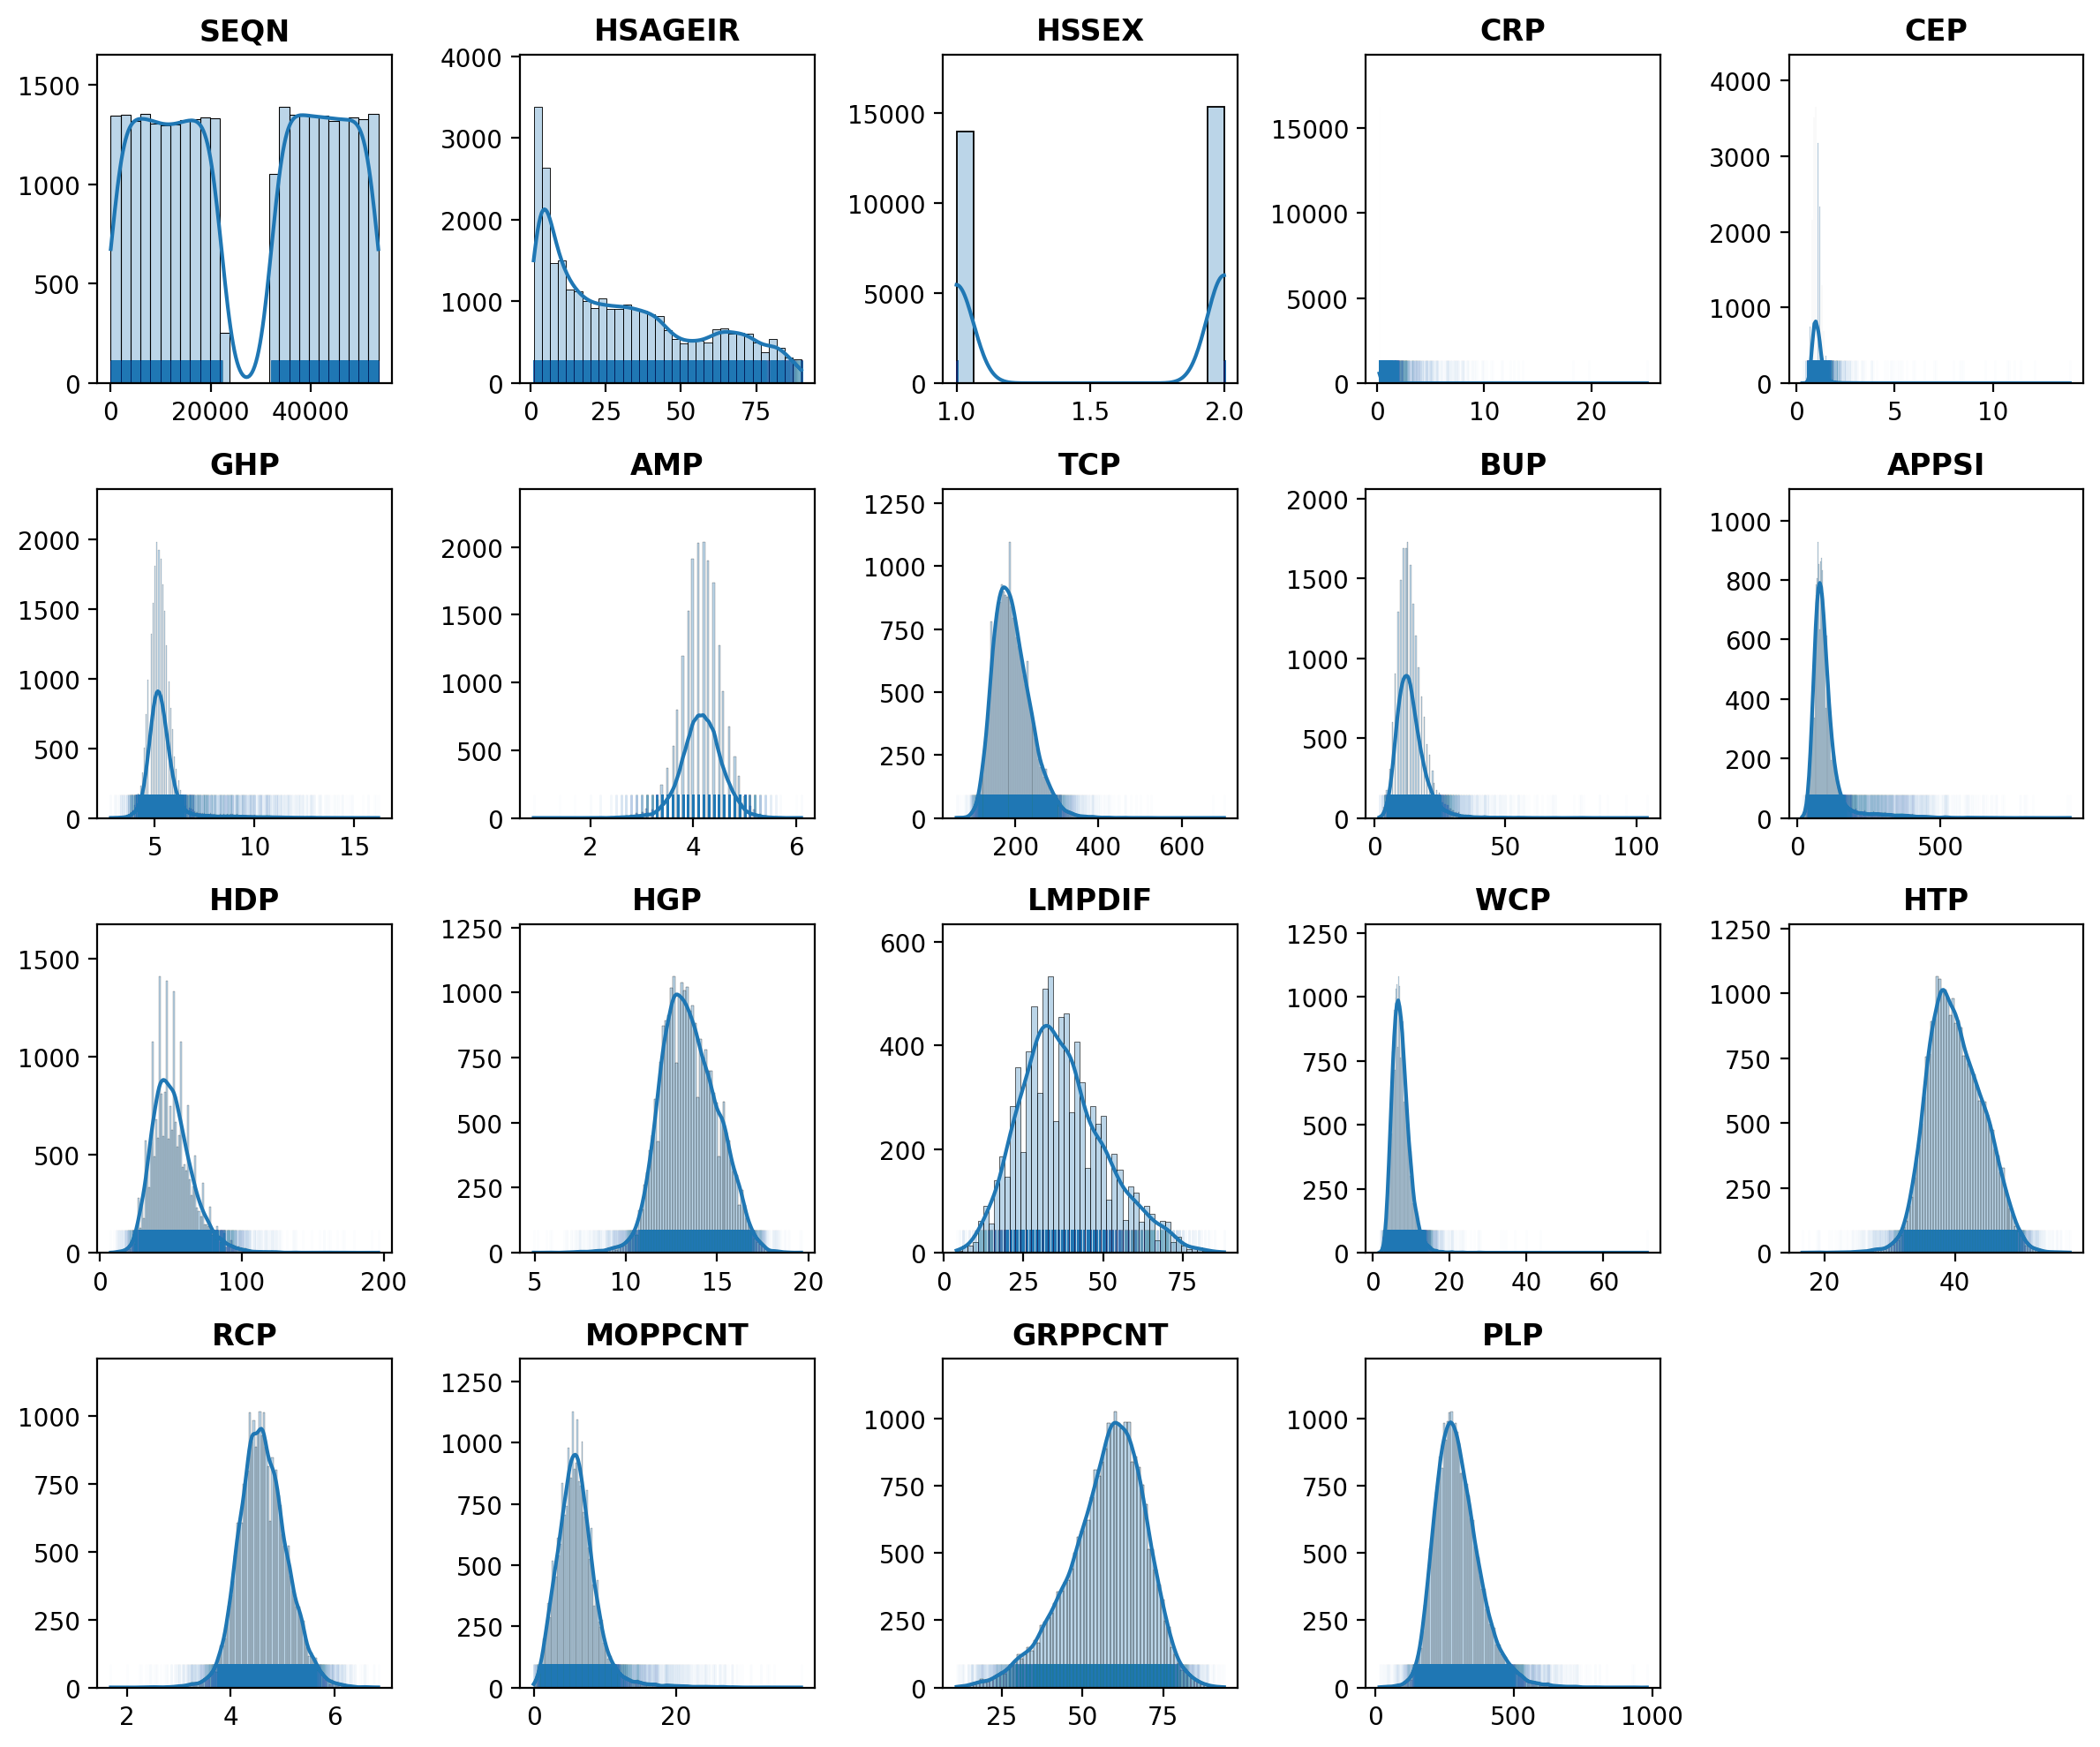

In [5]:
fig, axis = plt.subplots(nrows=4, ncols=5, figsize=(12, 10), dpi=200)

for col, ax in zip(cols, axis.ravel()):
    sns.histplot(data=df_lab, kde=True, legend=False, x=col, ax=ax, alpha=0.3)
    sns.rugplot(data=df_lab, alpha=0.01, x=col, ax=ax, height=0.07)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(col, fontweight='bold')
    
axis[-1][-1].axis('off')
plt.tight_layout()
plt.show()

## Examination File

In [6]:
# From exam.dat SAS code

# SEQN     = "Sample person identification number" [1, 5]

# SPPFEV05 = "Forced expiratory vol(FEV),.5 sec,max-ml" [4465, 4468]
# PEPMNK1R = "Overall average K1, systolic, BP(age 5+)" [1423, 1425]
# PEP6DR   = "Pulse rate (beats/min) (age 5+ years)" [1386, 1388]
# PEPMNK5R = "Overall average K5, diastolic, BP(age5+)" [1428, 1430]

In [7]:
cols = [
    'SEQN',
    'SPPFEV05',
#     'PEPMNK1R',
    'PEP6DR',
#     'PEPMNK5R'
]
 
ind = [
    [1, 5],
    [4465, 4468],
#     [1423, 1425],
    [1386, 1388],
#     [1428, 1430]
]

with open('data/exam.dat') as f:
    contents = f.readlines()

data = []

for line in contents:
    data_ = []
    for ind_ in ind:
        data_.append(line[ind_[0]-1:ind_[1]])
    data.append([float(i) if isNumber(i) else np.nan for i in data_])
    
exam_data = np.array(data)

df_exam = pd.DataFrame(dict(zip(cols, exam_data.T)))
df_exam.SEQN = df_exam.SEQN.astype('int')
print(df_exam.shape)
df_exam.head()

(31311, 3)


,SEQN,SPPFEV05,PEP6DR
0,3,3576.0,80.0
1,4,2545.0,80.0
2,7,NaN,NaN
3,9,1992.0,76.0
4,10,3260.0,72.0


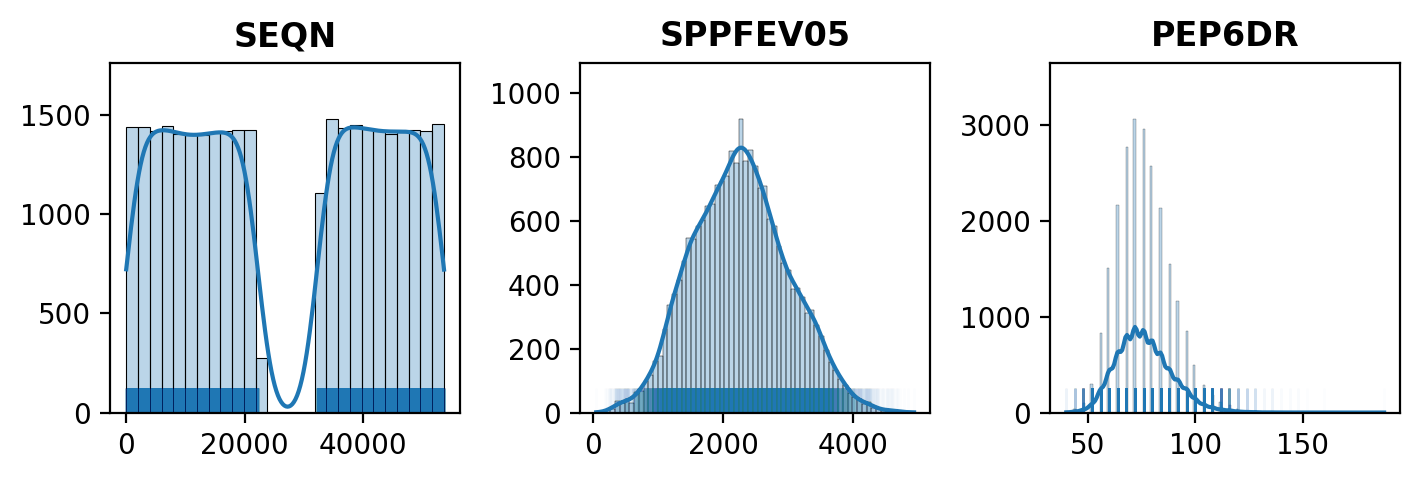

In [8]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(7.2, 2.5), dpi=200)

for col, ax in zip(cols, axis.ravel()):
    sns.histplot(data=df_exam, kde=True, legend=False, x=col, ax=ax, alpha=0.3)
    sns.rugplot(data=df_exam, alpha=0.01, x=col, ax=ax, height=0.07)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(col, fontweight='bold')
    
plt.tight_layout()
plt.show()

## Adult file

In [9]:
# check adult.dat

# HAZMNK1R = "Average K1 BP from household and MEC" [3337, 3339]
# HAZMNK5R = "Average K5 BP from household and MEC" [3342, 3344]

In [10]:
cols = [
    'SEQN',
    'HAZMNK1R',
    'HAZMNK5R'
]
 
ind = [
    [1, 5],
    [3337, 3339],
    [3342, 3344]
]

with open('data/adult.dat') as f:
    contents = f.readlines()

data = []

for line in contents:
    data_ = []
    for ind_ in ind:
        data_.append(line[ind_[0]-1:ind_[1]])
    data.append([float(i) if isNumber(i) else np.nan for i in data_])
    
adult_data = np.array(data)

df_adult = pd.DataFrame(dict(zip(cols, adult_data.T)))
df_adult.SEQN = df_adult.SEQN.astype('int')
print(df_adult.shape)
df_adult.head()

(20050, 3)


,SEQN,HAZMNK1R,HAZMNK5R
0,3,120.0,67.0
1,4,126.0,86.0
2,9,131.0,73.0
3,10,130.0,82.0
4,11,120.0,70.0


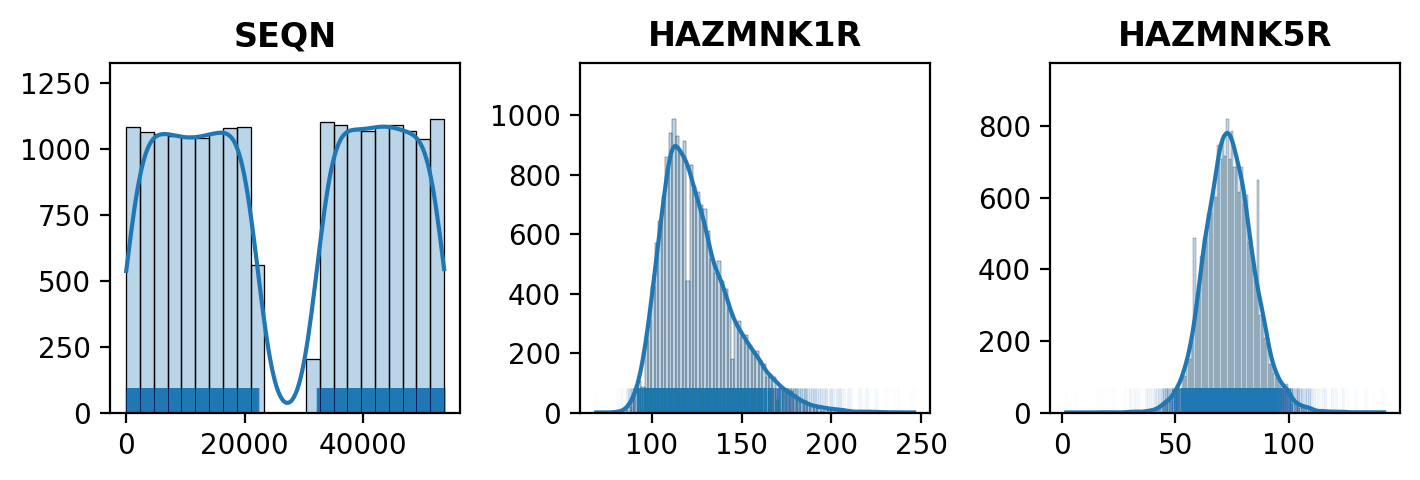

In [11]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(7.2, 2.5), dpi=200)

for col, ax in zip(cols, axis.ravel()):
    sns.histplot(data=df_adult, kde=True, legend=False, x=col, ax=ax, alpha=0.3)
    sns.rugplot(data=df_adult, alpha=0.01, x=col, ax=ax, height=0.07)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(col, fontweight='bold')
    
plt.tight_layout()
plt.show()

## Data 19A. Antibody to Cytomegalovirus IgG and IgM

In [12]:
# From cmv.xpt

# SEQN
# CVP_IGG "Cytomegalovirus optical density"

In [13]:
df_cyto = pd.read_sas('data/cmv.xpt', encoding = 'UTF-8')
print(df_cyto.shape)
df_cyto.SEQN = df_cyto.SEQN.astype('int')
df_cyto = df_cyto[['SEQN', 'CVP_IGG']]
df_cyto.head()

(21648, 4)


,SEQN,CVP_IGG
0,3,2.0
1,4,2.0
2,9,1.0
3,10,2.0
4,11,1.0


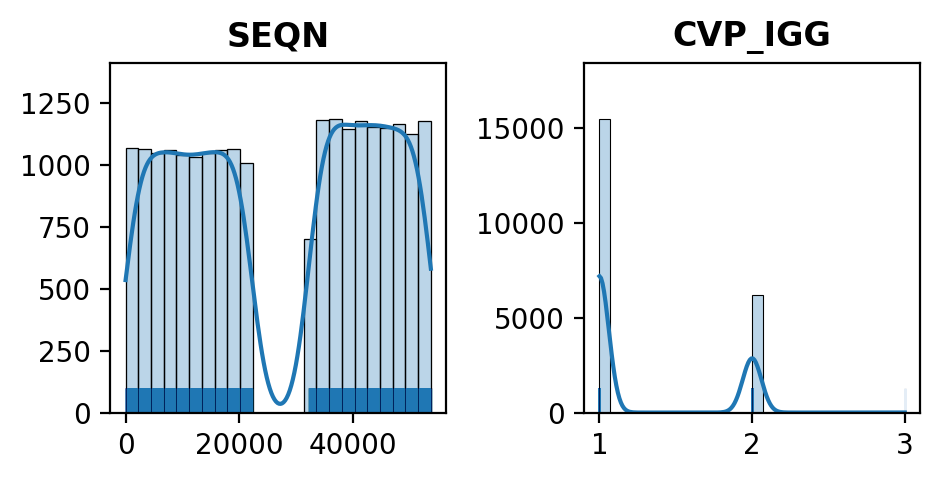

In [14]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(4.8, 2.5), dpi=200)

for col, ax in zip(['SEQN', 'CVP_IGG'], axis.ravel()):
    sns.histplot(data=df_cyto, kde=True, legend=False, x=col, ax=ax, alpha=0.3)
    sns.rugplot(data=df_cyto, alpha=0.01, x=col, ax=ax, height=0.07)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(col, fontweight='bold')
    
plt.tight_layout()
plt.show()

## Mortality

In [15]:
# SEQN ='NHANES Respondent Sequence Number'
# ELIGSTAT = 'Eligibility Status for Mortality Follow-up'
# MORTSTAT = 'Final Mortality Status'
# UCOD_LEADING = 'Underlying Leading Cause of Death: Recode'
# PERMTH_INT = 'Number of Person-Months of Follow-up from NHANES Interview date'
# PERMTH_EXM = 'Number of Person-Months of Follow-up from NHANES Mobile Examination Center (MEC) Date'

# SEQN [1, 6]
# ELIGSTAT [15, 15]
# MORTSTAT [16, 16]
# UCOD_LEADING [17, 19]
# PERMTH_INT [43, 45]
# PERMTH_EXM [46, 48]


#   ELIGSTAT
#     1 = "Eligible"
#     2 = "Under age 18, not available for public release"
#     3 = "Ineligible";

#   MORTSTAT
#     0 = "Assumed alive"
#     1 = "Assumed deceased"
#     . = "Ineligible or under age 18";

#   UCOD_LEADING
#     "001" = "Diseases of heart (I00-I09, I11, I13, I20-I51)"
#     "002" = "Malignant neoplasms (C00-C97)"
#     "003" = "Chronic lower respiratory diseases (J40-J47)"
#     "004" = "Accidents (unintentional injuries) (V01-X59, Y85-Y86)"
#     "005" = "Cerebrovascular diseases (I60-I69)"
#     "006" = "Alzheimer's disease (G30)"
#     "007" = "Diabetes mellitus (E10-E14)"
#     "008" = "Influenza and pneumonia (J09-J18)"
#     "009" = "Nephritis, nephrotic syndrome and nephrosis (N00-N07, N17-N19, N25-N27)"
#     "010" = "All other causes (residual)" 
#     "   " = "Ineligible, under age 18, assumed alive, or no cause of death data available";

In [16]:
cols = [
    'SEQN',
    'ELIGSTAT',
    'MORTSTAT',
    'UCOD_LEADING',
    'PERMTH_INT',
    'PERMTH_EXM'
]

ind = [
    [1, 6],
    [15, 15],
    [16, 16],
    [17, 19],
    [43, 45],
    [46, 48]
]

with open('data/NHANES_III_MORT_2019_PUBLIC.dat') as f:
    contents = f.readlines()
    
data = []

for line in contents:
    data_ = []
    for ind_ in ind:
        data_.append(line[ind_[0]-1:ind_[1]])
    data.append([float(i) if isNumber(i) else np.nan for i in data_])

data = np.array(data)

df_mort = pd.DataFrame(dict(zip(cols, data.T)))
df_mort.SEQN = df_mort.SEQN.astype('int')

print(df_mort[df_mort.UCOD_LEADING == 4].shape)
df_mort.loc[df_mort.UCOD_LEADING == 4, 'MORTSTAT'] = 0 # change status of people with "accidential" deaths
df_mort = df_mort[['SEQN', 'MORTSTAT', 'PERMTH_EXM']]
df_mort.loc[df_mort.MORTSTAT.isna(), 'MORTSTAT'] = 0
# df_mort = df_mort[(~df_mort.MORTSTAT.isna()) & (~df_mort.PERMTH_EXM.isna())]

print(df_mort.shape)
df_mort.head()

(233, 6)
(33994, 3)


,SEQN,MORTSTAT,PERMTH_EXM
0,3,0.0,353.0
1,4,0.0,341.0
2,7,0.0,NaN
3,9,0.0,354.0
4,10,0.0,344.0


In [17]:
df_mort.MORTSTAT.value_counts()

MORTSTAT
0.0    25604
1.0     8390
Name: count, dtype: int64

# Aggregate data

In [51]:
df = df_lab.merge(df_exam, left_on='SEQN', right_on='SEQN').merge(df_adult, left_on='SEQN', right_on='SEQN').merge(df_cyto, left_on='SEQN', right_on='SEQN').merge(df_mort, left_on='SEQN', right_on='SEQN')
print(df.shape)

df = df[(df.HSAGEIR > 30) & (df.HSAGEIR < 75)]
print(df.shape)
df = df[~df.PERMTH_EXM.isna()]
print(df.shape)

df.head()



(17083, 26)
(10727, 26)
(10649, 26)


,SEQN,HSAGEIR,HSSEX,CRP,CEP,GHP,AMP,TCP,BUP,APPSI,...,MOPPCNT,GRPPCNT,PLP,SPPFEV05,PEP6DR,HAZMNK1R,HAZMNK5R,CVP_IGG,MORTSTAT,PERMTH_EXM
1,4,32.000000,2.0,0.21,0.7,4.6,4.1,160.0,11.0,89.0,...,3.4,67.50,441.5,2545.0,80.0,126.0,86.0,2.0,0.0,341.0
2,9,48.583333,2.0,0.21,0.8,5.3,4.0,236.0,14.0,59.0,...,2.9,64.75,235.5,1992.0,76.0,131.0,73.0,1.0,0.0,354.0
3,10,35.666667,1.0,0.21,1.2,4.6,4.5,225.0,14.0,74.0,...,4.3,68.50,180.0,3260.0,72.0,130.0,82.0,2.0,0.0,344.0
4,11,48.500000,1.0,0.33,1.1,9.1,4.1,260.0,14.0,91.0,...,5.2,68.85,443.0,2502.0,84.0,120.0,70.0,1.0,1.0,206.0
5,19,44.250000,1.0,0.21,1.1,5.7,4.2,187.0,10.0,86.0,...,NaN,NaN,75.0,1965.0,76.0,133.0,85.0,1.0,1.0,65.0


# Analysis

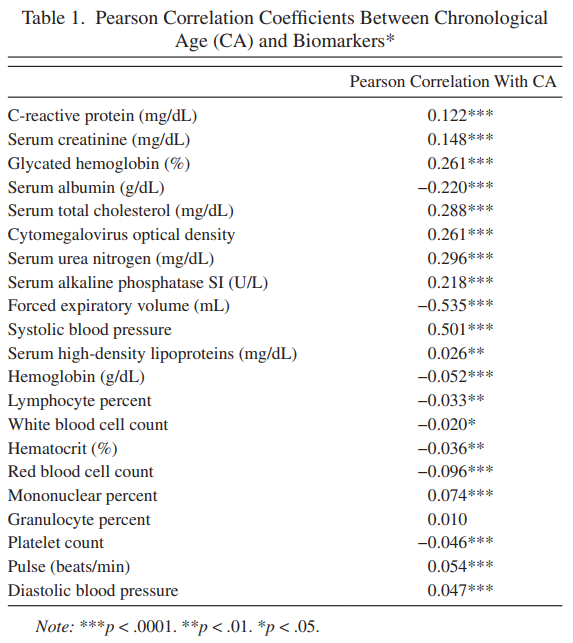

In [52]:
cols = [
    'CRP',
    'CEP',
    'GHP',
    'AMP',
    'TCP',
    'CVP_IGG',
    'BUP',
    'APPSI',
    'SPPFEV05',
    'HAZMNK1R',
    'HDP',
    'HGP',
    'LMPDIF',
    'WCP',
    'HTP',
    'RCP',
    'MOPPCNT',
    'GRPPCNT',
    'PLP',
    'PEP6DR',
    'HAZMNK5R'
]

dict_col_decription = {
    'CRP':'Serum C-reactive protein (mg/dL)',
    'CEP':'Serum creatinine (mg/dL)',
    'GHP':'Glycated hemoglobin: (%)',
    'AMP':'Serum albumin (g/dL)',
    'TCP':'Serum cholesterol (mg/dL)',
    'CVP_IGG':'Cytomegalovirus optical density',
    'BUP':'Serum blood urea nitrogen (mg/dL)',
    'APPSI':'Serum alkaline phosphatase:  SI (U/L)',
    'SPPFEV05':'Forced expiratory vol(FEV),.5 sec,max-ml',
    'HAZMNK1R':'Average K1 BP from household and MEC',
    'HDP':'Serum HDL cholesterol (mg/dL)',
    'HGP':'Hemoglobin (g/dL)',
    'LMPDIF':'Lymphocytes (percent of 100 cells)',
    'WCP':'White blood cell count',
    'HTP':'Hematocrit (%)',
    'RCP':'Red blood cell count',
    'MOPPCNT':'Mononuclear percent (Coulter)',
    'GRPPCNT':'Granulocyte percent (Coulter)',
    'PLP':'Platelet count',
    'PEP6DR':'Pulse rate (beats/min) (age 5+ years)',
    'HAZMNK5R':'Average K5 BP from household and MEC'
}

table1 = {'Biomarker':[], 'r':[], 'signif.':[], 'p-value':[]}

for col in cols:
    r, pv = stats.pearsonr(df[~df[col].isna()].HSAGEIR, df[~df[col].isna()][col])
    table1['Biomarker'] = table1['Biomarker'] + [dict_col_decription[col]]
    table1['p-value'] = table1['p-value'] + [round(pv, 6)]
    if pv > 0.05:
        sign = ' '
    elif pv > 0.01:
        sign = '*'
    elif pv > .0001:
        sign = '**'
    else:
        sign = '***'
    table1['signif.'] = table1['signif.'] + [sign]
    table1['r'] = table1['r'] + [round(r, 3)]
    print(f'r={r:.3f}, p={pv:.6f}', dict_col_decription[col])
    
table1 = pd.DataFrame(table1)

r=0.077, p=0.000000 Serum C-reactive protein (mg/dL)
r=0.146, p=0.000000 Serum creatinine (mg/dL)
r=0.240, p=0.000000 Glycated hemoglobin: (%)
r=-0.141, p=0.000000 Serum albumin (g/dL)
r=0.267, p=0.000000 Serum cholesterol (mg/dL)
r=-0.180, p=0.000000 Cytomegalovirus optical density
r=0.330, p=0.000000 Serum blood urea nitrogen (mg/dL)
r=0.180, p=0.000000 Serum alkaline phosphatase:  SI (U/L)
r=-0.480, p=0.000000 Forced expiratory vol(FEV),.5 sec,max-ml
r=0.492, p=0.000000 Average K1 BP from household and MEC
r=-0.001, p=0.907678 Serum HDL cholesterol (mg/dL)
r=0.017, p=0.089902 Hemoglobin (g/dL)
r=-0.064, p=0.000384 Lymphocytes (percent of 100 cells)
r=-0.022, p=0.026001 White blood cell count
r=0.025, p=0.011107 Hematocrit (%)
r=-0.050, p=0.000000 Red blood cell count
r=0.056, p=0.000000 Mononuclear percent (Coulter)
r=0.043, p=0.000012 Granulocyte percent (Coulter)
r=-0.102, p=0.000000 Platelet count
r=0.039, p=0.000065 Pulse rate (beats/min) (age 5+ years)
r=0.022, p=0.026182 Avera

### Table 1

Note that I have some differences in $r$ and $p$ values with paper for small Pearson's $R$ values

In [53]:
table1

,Biomarker,r,signif.,p-value
0,Serum C-reactive protein (mg/dL),0.077,***,0.000000
1,Serum creatinine (mg/dL),0.146,***,0.000000
2,Glycated hemoglobin: (%),0.240,***,0.000000
3,Serum albumin (g/dL),-0.141,***,0.000000
4,Serum cholesterol (mg/dL),0.267,***,0.000000
5,Cytomegalovirus optical density,-0.180,***,0.000000
6,Serum blood urea nitrogen (mg/dL),0.330,***,0.000000
7,Serum alkaline phosphatase: SI (U/L),0.180,***,0.000000
8,"Forced expiratory vol(FEV),.5 sec,max-ml",-0.480,***,0.000000
9,Average K1 BP from household and MEC,0.492,***,0.000000


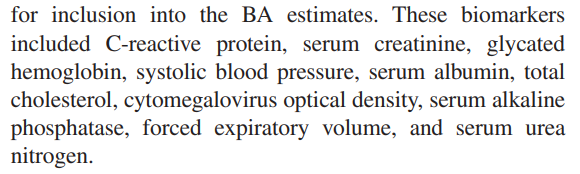

In [54]:
cols = [
    'CRP',
    'CEP',
    'GHP',
    'HAZMNK1R',
    'AMP',
    'TCP',
    'CVP_IGG',
    'APPSI',
    'SPPFEV05',
    'BUP'
]

df = df[~df[cols].isna().any(axis=1)]

In [55]:
df.shape

(9717, 26)

In [63]:
# df.to_csv('df.csv')
df = pd.read_csv('df.csv', index_col=0)
df

,SEQN,HSAGEIR,HSSEX,CRP,CEP,GHP,AMP,TCP,BUP,APPSI,...,MOPPCNT,GRPPCNT,PLP,SPPFEV05,PEP6DR,HAZMNK1R,HAZMNK5R,CVP_IGG,MORTSTAT,PERMTH_EXM
1,4,32.000000,2.0,0.21,0.7,4.6,4.1,160.0,11.0,89.0,...,3.40,67.50,441.5,2545.0,80.0,126.0,86.0,2.0,0.0,341.0
2,9,48.583333,2.0,0.21,0.8,5.3,4.0,236.0,14.0,59.0,...,2.90,64.75,235.5,1992.0,76.0,131.0,73.0,1.0,0.0,354.0
3,10,35.666667,1.0,0.21,1.2,4.6,4.5,225.0,14.0,74.0,...,4.30,68.50,180.0,3260.0,72.0,130.0,82.0,2.0,0.0,344.0
4,11,48.500000,1.0,0.33,1.1,9.1,4.1,260.0,14.0,91.0,...,5.20,68.85,443.0,2502.0,84.0,120.0,70.0,1.0,1.0,206.0
5,19,44.250000,1.0,0.21,1.1,5.7,4.2,187.0,10.0,86.0,...,NaN,NaN,75.0,1965.0,76.0,133.0,85.0,1.0,1.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17070,53572,39.250000,2.0,0.30,1.0,5.0,4.0,214.0,9.0,59.0,...,6.60,49.65,237.0,1962.0,68.0,113.0,70.0,1.0,0.0,310.0
17071,53575,66.750000,1.0,0.21,1.1,5.8,3.9,184.0,19.0,64.0,...,6.10,59.30,198.5,1881.0,72.0,157.0,85.0,1.0,1.0,226.0
17072,53581,35.833333,1.0,0.21,1.2,5.3,4.4,196.0,13.0,75.0,...,6.15,51.25,420.0,3195.0,76.0,129.0,90.0,1.0,1.0,114.0
17075,53585,58.166667,1.0,1.60,1.1,7.6,4.1,215.0,15.0,159.0,...,7.15,63.40,178.0,2076.0,76.0,135.0,65.0,1.0,1.0,177.0


In [23]:
cols = [
    'CRP',
    'CEP',
    'GHP',
    'AMP',
    'TCP',
    'CVP_IGG',
    'BUP',
    'APPSI',
    'SPPFEV05',
    'HAZMNK1R',
    'HDP',
    'HGP',
    'LMPDIF',
    'WCP',
    'HTP',
    'RCP',
    'MOPPCNT',
    'GRPPCNT',
    'PLP',
    'PEP6DR',
    'HAZMNK5R'
]

dict_col_decription = {
    'CRP':'Serum C-reactive protein (mg/dL)',
    'CEP':'Serum creatinine (mg/dL)',
    'GHP':'Glycated hemoglobin: (%)',
    'AMP':'Serum albumin (g/dL)',
    'TCP':'Serum cholesterol (mg/dL)',
    'CVP_IGG':'Cytomegalovirus optical density',
    'BUP':'Serum blood urea nitrogen (mg/dL)',
    'APPSI':'Serum alkaline phosphatase:  SI (U/L)',
    'SPPFEV05':'Forced expiratory vol(FEV),.5 sec,max-ml',
    'HAZMNK1R':'Average K1 BP from household and MEC',
    'HDP':'Serum HDL cholesterol (mg/dL)',
    'HGP':'Hemoglobin (g/dL)',
    'LMPDIF':'Lymphocytes (percent of 100 cells)',
    'WCP':'White blood cell count',
    'HTP':'Hematocrit (%)',
    'RCP':'Red blood cell count',
    'MOPPCNT':'Mononuclear percent (Coulter)',
    'GRPPCNT':'Granulocyte percent (Coulter)',
    'PLP':'Platelet count',
    'PEP6DR':'Pulse rate (beats/min) (age 5+ years)',
    'HAZMNK5R':'Average K5 BP from household and MEC'
}

for col in cols:
    r, pv = stats.pearsonr(df[~df[col].isna()].HSAGEIR, df[~df[col].isna()][col])
    
    print(f'r={r:.3f}, p={pv:.6f}', dict_col_decription[col])

r=0.075, p=0.000000 Serum C-reactive protein (mg/dL)
r=0.142, p=0.000000 Serum creatinine (mg/dL)
r=0.241, p=0.000000 Glycated hemoglobin: (%)
r=-0.142, p=0.000000 Serum albumin (g/dL)
r=0.274, p=0.000000 Serum cholesterol (mg/dL)
r=-0.182, p=0.000000 Cytomegalovirus optical density
r=0.331, p=0.000000 Serum blood urea nitrogen (mg/dL)
r=0.177, p=0.000000 Serum alkaline phosphatase:  SI (U/L)
r=-0.479, p=0.000000 Forced expiratory vol(FEV),.5 sec,max-ml
r=0.499, p=0.000000 Average K1 BP from household and MEC
r=0.002, p=0.871383 Serum HDL cholesterol (mg/dL)
r=0.024, p=0.016581 Hemoglobin (g/dL)
r=-0.054, p=0.004628 Lymphocytes (percent of 100 cells)
r=-0.023, p=0.021485 White blood cell count
r=0.033, p=0.001034 Hematocrit (%)
r=-0.040, p=0.000085 Red blood cell count
r=0.059, p=0.000000 Mononuclear percent (Coulter)
r=0.037, p=0.000326 Granulocyte percent (Coulter)
r=-0.103, p=0.000000 Platelet count
r=0.037, p=0.000331 Pulse rate (beats/min) (age 5+ years)
r=0.028, p=0.006272 Averag

In [24]:
cols = [
    'CRP',
    'CEP',
    'GHP',
    'HAZMNK1R',
    'AMP',
    'TCP',
    'CVP_IGG',
    'APPSI',
    'SPPFEV05',
    'BUP'
]

df = df[['SEQN', 'HSAGEIR', 'HSSEX', 'MORTSTAT', 'PERMTH_EXM']+cols]

for col in cols:
    r, pv = stats.pearsonr(df.HSAGEIR, df[col])
    
    print(f'r={r:.3f}, p={pv:.6f}', dict_col_decription[col])

r=0.075, p=0.000000 Serum C-reactive protein (mg/dL)
r=0.142, p=0.000000 Serum creatinine (mg/dL)
r=0.241, p=0.000000 Glycated hemoglobin: (%)
r=0.499, p=0.000000 Average K1 BP from household and MEC
r=-0.142, p=0.000000 Serum albumin (g/dL)
r=0.274, p=0.000000 Serum cholesterol (mg/dL)
r=-0.182, p=0.000000 Cytomegalovirus optical density
r=0.177, p=0.000000 Serum alkaline phosphatase:  SI (U/L)
r=-0.479, p=0.000000 Forced expiratory vol(FEV),.5 sec,max-ml
r=0.331, p=0.000000 Serum blood urea nitrogen (mg/dL)


In [25]:
df.MORTSTAT.value_counts()

MORTSTAT
0.0    5612
1.0    4105
Name: count, dtype: int64

In [26]:
df[(df.HSAGEIR >= 60) & (df.HSAGEIR < 75)].MORTSTAT.value_counts()

MORTSTAT
1.0    2399
0.0     459
Name: count, dtype: int64

In [27]:
df[(df.HSAGEIR > 30) & (df.HSAGEIR <= 59)].MORTSTAT.value_counts()

MORTSTAT
0.0    5117
1.0    1630
Name: count, dtype: int64

In [28]:
df.head()

,SEQN,HSAGEIR,HSSEX,MORTSTAT,PERMTH_EXM,CRP,CEP,GHP,HAZMNK1R,AMP,TCP,CVP_IGG,APPSI,SPPFEV05,BUP
1,4,32.000000,2.0,0.0,341.0,0.21,0.7,4.6,126.0,4.1,160.0,2.0,89.0,2545.0,11.0
2,9,48.583333,2.0,0.0,354.0,0.21,0.8,5.3,131.0,4.0,236.0,1.0,59.0,1992.0,14.0
3,10,35.666667,1.0,0.0,344.0,0.21,1.2,4.6,130.0,4.5,225.0,2.0,74.0,3260.0,14.0
4,11,48.500000,1.0,1.0,206.0,0.33,1.1,9.1,120.0,4.1,260.0,1.0,91.0,2502.0,14.0
5,19,44.250000,1.0,1.0,65.0,0.21,1.1,5.7,133.0,4.2,187.0,1.0,86.0,1965.0,10.0


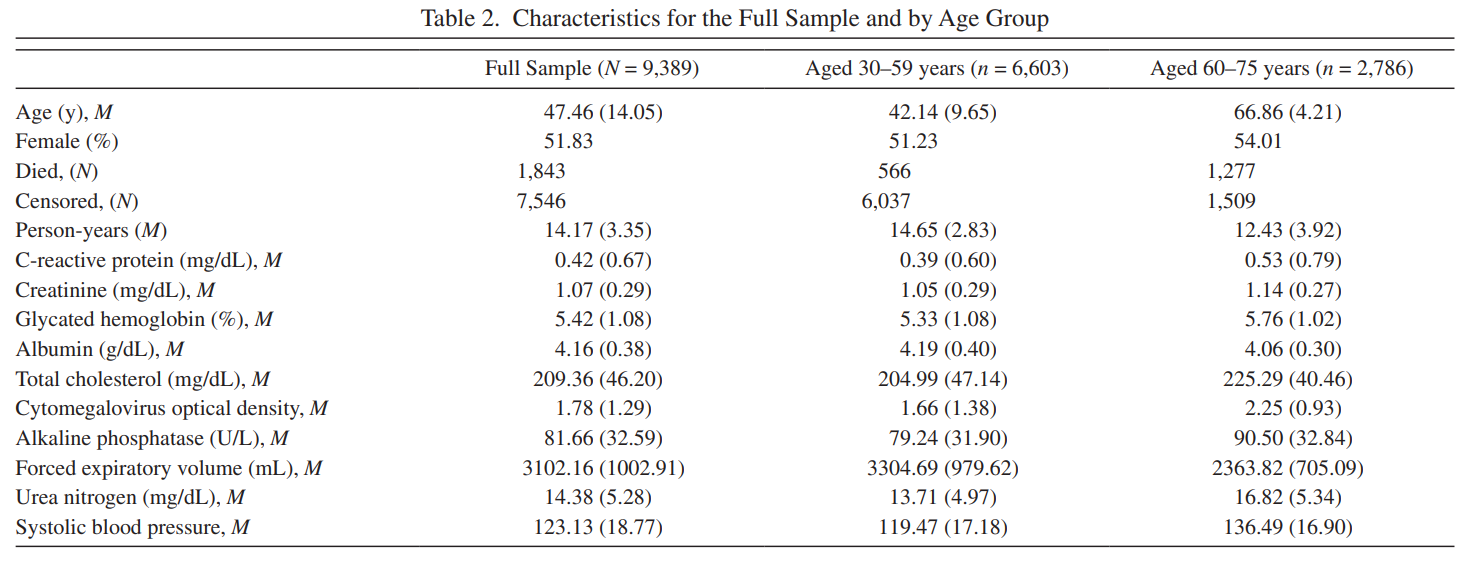

In [29]:
age_group_masks = [
    (df.HSAGEIR > 30),
    (df.HSAGEIR > 30) & (df.HSAGEIR <= 59),
    (df.HSAGEIR >= 60) & (df.HSAGEIR < 75)
]

age_group_names = [
    f'Full sample (N = {int(age_group_masks[0].sum())})',
    f'Aged 30–59 years (n = {int(age_group_masks[1].sum())})',
    f'Aged 60–75 years (n = {int(age_group_masks[2].sum())})'
]

indices = [
    'Age (y), M (std)',
    'Female, %',
    'Died, N',
    'Censored, N',
    'Person-years, M (std)'
]

values = []
switch = True
for mask in age_group_masks:
    val = [
        f'{df[mask].HSAGEIR.mean():.2f}, ({df[mask].HSAGEIR.std():.2f})',
        f'{(df[mask].HSSEX == 2).sum() * 100 / mask.sum() : .2f}',
        f'{(df[mask].MORTSTAT == 1).sum()}',
        f'{(df[mask].MORTSTAT == 0).sum()}',
        f'{df[mask].PERMTH_EXM.mean() / 12:.2f}, ({(df[mask].PERMTH_EXM/ 12).std() :.2f})'
    ]
    
    for col in cols:
        val += [f'{df[mask][col].mean():.2f}, ({df[mask][col].std():.2f})']
        if switch:
            indices += [dict_col_decription[col] + ', M (std)']
    switch = False
    values.append(val)
    
values = np.array(values)

table2 = pd.DataFrame(data=values.T, index=indices, columns=age_group_names)

### Table 2

Note that I use newer version of mortality data (from 2019 compared with 2006 used in paper) - so I have more people died

In [30]:
table2

,Full sample (N = 9717),Aged 30–59 years (n = 6747),Aged 60–75 years (n = 2858)
"Age (y), M (std)","49.96, (13.34)","42.53, (8.17)","67.13, (4.31)"
"Female, %",52.85,54.26,49.51
"Died, N",4105,1630,2399
"Censored, N",5612,5117,459
"Person-years, M (std)","22.74, (7.91)","25.41, (6.04)","16.52, (8.27)"
"Serum C-reactive protein (mg/dL), M (std)","0.50, (0.84)","0.46, (0.68)","0.59, (1.12)"
"Serum creatinine (mg/dL), M (std)","1.08, (0.41)","1.05, (0.34)","1.17, (0.52)"
"Glycated hemoglobin: (%), M (std)","5.66, (1.24)","5.51, (1.14)","6.01, (1.37)"
"Average K1 BP from household and MEC, M (std)","126.50, (18.64)","121.27, (15.83)","138.65, (19.13)"
"Serum albumin (g/dL), M (std)","4.12, (0.36)","4.15, (0.36)","4.06, (0.35)"


# Bilogical Age estimates

## Principal component analysis

In [31]:
df_norm = df.copy()
df_norm[cols] = (df[cols]-df[cols].mean())/df[cols].std()

Men
explained_variance_ratio_ [0.20902555 0.14779818 0.11224068 0.10608871]
eigenvalues [1.98370342 1.40264076 1.06519141 1.0068077 ]
Correlations of variables with the first component
r=0.176, p=0.000000 Serum cholesterol (mg/dL)
r=0.337, p=0.000000 Serum C-reactive protein (mg/dL)
r=0.383, p=0.000000 Serum alkaline phosphatase:  SI (U/L)
r=-0.393, p=0.000000 Cytomegalovirus optical density
r=0.455, p=0.000000 Serum blood urea nitrogen (mg/dL)
r=0.473, p=0.000000 Glycated hemoglobin: (%)
r=0.504, p=0.000000 Serum creatinine (mg/dL)
r=-0.510, p=0.000000 Serum albumin (g/dL)
r=0.523, p=0.000000 Average K1 BP from household and MEC
r=-0.635, p=0.000000 Forced expiratory vol(FEV),.5 sec,max-ml

Women
explained_variance_ratio_ [0.24496239 0.14774057 0.11822251 0.09269105]
eigenvalues [2.35145248 1.41819699 1.13484615 0.88976348]
Correlations of variables with the first component
r=-0.279, p=0.000000 Cytomegalovirus optical density
r=-0.303, p=0.000000 Serum albumin (g/dL)
r=0.339, p=0.0000

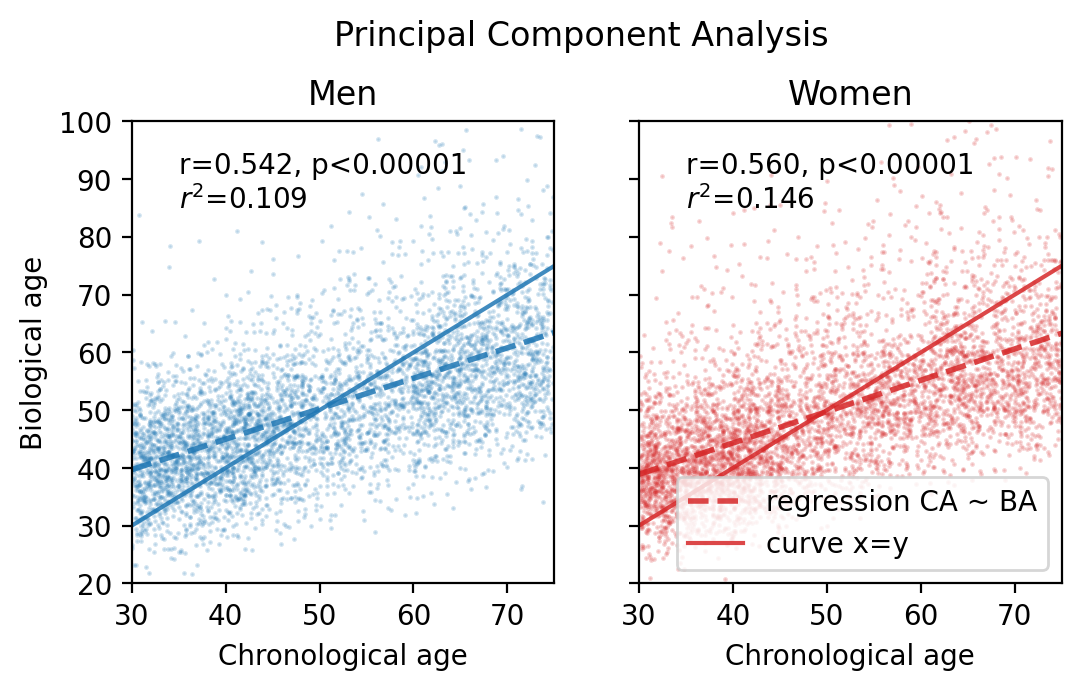

In [32]:
pca_ba_mf = []
n_components = 4 #len(cols)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), dpi=200, sharex=True, sharey=True)

for sex in [1, 2]:
    
    print(['Men', 'Women'][sex-1])
    pca = PCA(n_components=n_components, whiten=True)
    pca_res = pca.fit_transform(df_norm[df_norm.HSSEX == sex][cols])
    print('explained_variance_ratio_', pca.explained_variance_ratio_)
    eigenvalues = pca.explained_variance_
    print('eigenvalues', eigenvalues)

    print('Correlations of variables with the first component')
    rs = []
    for col in cols:
        r, pv = stats.pearsonr(df_norm[df_norm.HSSEX == sex][col], pca_res[:, 0])  
        rs.append(r)
    cols_sort = sorted(cols, key=lambda i:abs(dict(zip(cols, rs))[i]))
    for col in cols_sort:
        r, pv = stats.pearsonr(df_norm[df_norm.HSSEX == sex][col], pca_res[:, 0])  
        print(f'r={r:.3f}, p={pv:.6f}', dict_col_decription[col])

    pca_ba = pca_res[:, 0] # First PCA
    # pca_ba = (pca_ba - pca_ba.mean()) / pca_ba.std()
    # Convert to BA
    pca_ba = pca_ba * df_norm[df_norm.HSSEX == sex].HSAGEIR.std() + df_norm[df_norm.HSSEX == sex].HSAGEIR.mean() 
    a, b = np.polyfit(pca_ba, df_norm[df_norm.HSSEX == sex].HSAGEIR, deg=1)
    # Add z scores to get True BA (TBA)
    pca_ba = pca_ba + (df_norm[df_norm.HSSEX == sex].HSAGEIR - df_norm[df_norm.HSSEX == sex].HSAGEIR.mean()) / (1-b) 
    a, b = np.polyfit(df_norm[df_norm.HSSEX == sex].HSAGEIR, pca_ba, deg=1)

    score = r2_score(df_norm[df_norm.HSSEX == sex].HSAGEIR, pca_ba)
    axes[sex-1].scatter(df_norm[df_norm.HSSEX == sex].HSAGEIR, pca_ba, s=0.5, alpha=.2, color={1:'tab:blue', 2:'tab:red'}[sex])
    pca_ba_mf.append(pca_ba)
    axes[sex-1].plot(np.arange(30, 76), np.arange(30, 76)*a+b, alpha=.85, linewidth=2, linestyle='--', 
                     color={1:'tab:blue', 2:'tab:red'}[sex], label='regression CA ~ BA')
    axes[sex-1].plot(np.arange(30, 76), np.arange(30, 76), alpha=.85, label='curve x=y', color={1:'tab:blue', 2:'tab:red'}[sex])

    r, pv = stats.pearsonr(df[df.HSSEX == sex].HSAGEIR, pca_ba)
    axes[sex-1].text(35, 85, f'r={r:.3f}, p<0.00001\n$r^2$={score:.3f}')

    axes[sex-1].set_ylim(20, 100)
    axes[sex-1].set_xlim(30, 75)

    axes[sex-1].set_xlabel('Chronological age')
    
    print()
    
axes[0].set_ylabel('Biological age')
axes[0].set_title('Men')
axes[1].set_title('Women')
axes[1].legend(loc='lower right')

plt.suptitle('Principal Component Analysis', y=1.05)

plt.show()

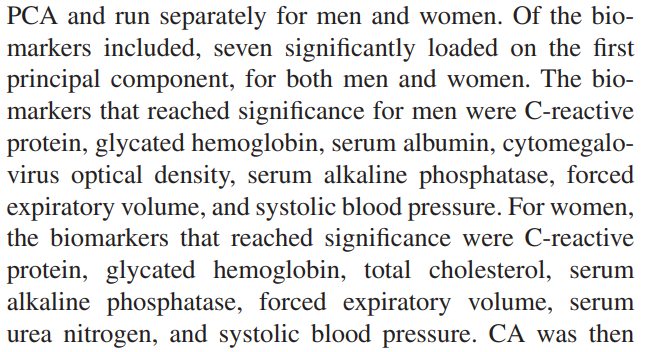

## Multiple linear regression

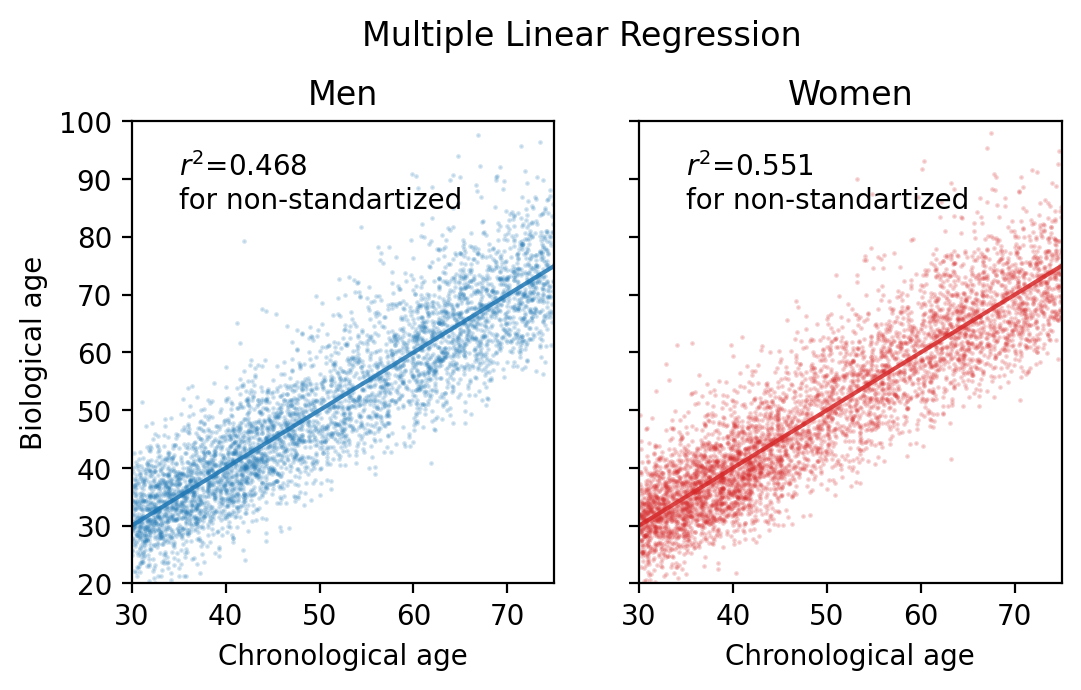

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), dpi=200, sharex=True, sharey=True)

mlr_mf = []

for sex in [1, 2]:

    lr = LinearRegression()
    lr.fit(df_norm[df_norm.HSSEX == sex][cols], df_norm[df_norm.HSSEX == sex].HSAGEIR)
    y_pred = lr.predict(df_norm[df_norm.HSSEX == sex][cols])
    score = r2_score(df_norm[df_norm.HSSEX == sex].HSAGEIR, y_pred)

    # The results from the equations were then standardized so
    # that the mean BA for participants of a given age was equalto CA.
    a, b = np.polyfit(df_norm[df_norm.HSSEX == sex].HSAGEIR, y_pred, deg=1)
    y_pred = y_pred - df_norm[df_norm.HSSEX == sex].HSAGEIR*a
    y_pred = y_pred - y_pred.mean()
    y_pred = y_pred + df_norm[df_norm.HSSEX == sex].HSAGEIR


    axes[sex-1].scatter(df_norm[df_norm.HSSEX == sex].HSAGEIR, y_pred, s=0.5, alpha=.2, color={1:'tab:blue', 2:'tab:red'}[sex])
    mlr_mf.append(y_pred)
    # axes[sex-1].plot(np.arange(30, 76), np.arange(30, 76)*a+b, alpha=.85, linewidth=2, linestyle='--')
    axes[sex-1].plot(np.arange(30, 76), np.arange(30, 76), alpha=.85, color={1:'tab:blue', 2:'tab:red'}[sex], label='curve x=y')
    axes[sex-1].text(35, 85, f'$r^2$={score:.3f}\nfor non-standartized')

    axes[sex-1].set_ylim(20, 100)
    axes[sex-1].set_xlim(30, 75)

    axes[sex-1].set_xlabel('Chronological age')
    
axes[0].set_ylabel('Biological age')
axes[0].set_title('Men')
axes[1].set_title('Women')

plt.suptitle('Multiple Linear Regression', y=1.05)
plt.show()

## Klemera and Doubal’s method

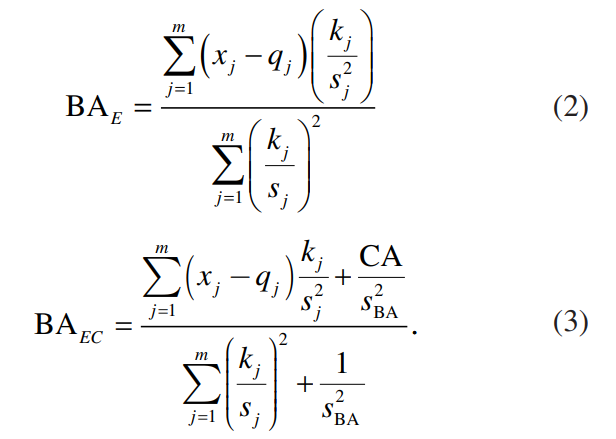

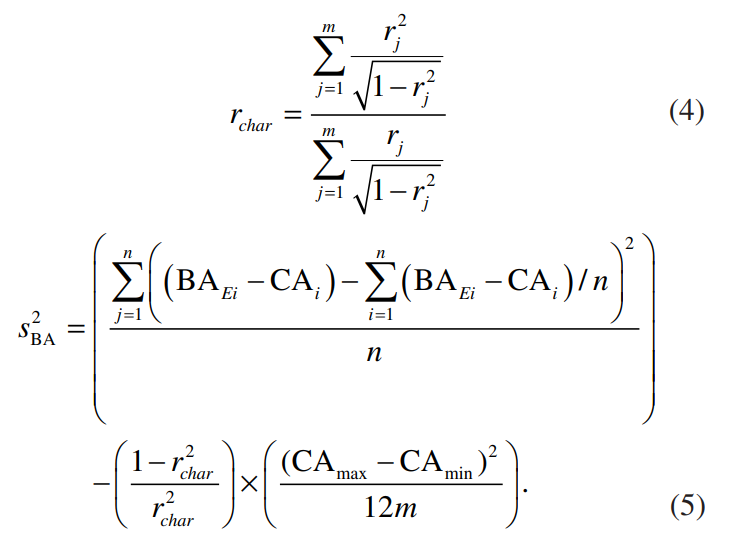

where $x_j$ is a set of biomarker values, $k_j$ is a slope, $q_j$ is intercept 

$s_j$ i a root mean squared error of a biomarker regressed on chronological age

$m$ is number of biomarkers used

In [34]:
kl_mf = []

sex = 1
m = 10

k = []
q = []
s = []
r2 = []
for col in cols:
    k_j, q_j = np.polyfit(df_norm[df_norm.HSSEX == sex].HSAGEIR,
                          df_norm[df_norm.HSSEX == sex][col], deg=1)
    k.append(k_j)
    q.append(q_j)
    
    pred = df_norm[df_norm.HSSEX == sex].HSAGEIR * k_j + q_j
    r2_j = r2_score(df_norm[df_norm.HSSEX == sex][col], pred)
    s_j = (((pred - df_norm[df_norm.HSSEX == sex][col])**2).sum() / len(pred)) **0.5
    s.append(s_j)
    r2.append(r2_j)
    
k = np.array(k)
q = np.array(q)
s = np.array(s)
r2 = np.array(r2)

ba_e = ((np.array(df_norm[df_norm.HSSEX == sex][cols]) - q) * (k / (s**2))).sum(axis=1) \
        / (((k/s)**2).sum())

r_char = ( r2/((1-r2)**0.5) ).sum() / (( (r2**0.5)/((1-r2)**0.5) ).sum())

ca = df_norm[df_norm.HSSEX == sex].HSAGEIR # chronological age
s2_ba = (((ba_e - ca) - (ba_e - ca).sum()/len(pred))**2).sum() / len(pred) - \
        ((1-r_char**2)/(r_char**2)) * \
        (((ca.max()-ca.min())**2)/(12*m))

ba_ec = (((np.array(df_norm[df_norm.HSSEX == sex][cols]) - q) * (k / (s**2))).sum(axis=1) + ca/s2_ba) / \
        (((k/s)**2).sum() + 1 / s2_ba)

kl_mf.append(ba_ec)
print('Men')
print('s2_ba', s2_ba)
print('r2_score', r2_score(ca, ba_ec))

sex = 2
m = 10

k = []
q = []
s = []
r2 = []
for col in cols:
    k_j, q_j = np.polyfit(df_norm[df_norm.HSSEX == sex].HSAGEIR,
                          df_norm[df_norm.HSSEX == sex][col], deg=1)
    k.append(k_j)
    q.append(q_j)
    
    pred = df_norm[df_norm.HSSEX == sex].HSAGEIR * k_j + q_j
    r2_j = r2_score(df_norm[df_norm.HSSEX == sex][col], pred)
    s_j = (((pred - df_norm[df_norm.HSSEX == sex][col])**2).sum() / len(pred)) **0.5
    s.append(s_j)
    r2.append(r2_j)
    
k = np.array(k)
q = np.array(q)
s = np.array(s)
r2 = np.array(r2)

ba_e = ((np.array(df_norm[df_norm.HSSEX == sex][cols]) - q) * (k / (s**2))).sum(axis=1) \
        / (((k/s)**2).sum())

r_char = ( r2/((1-r2)**0.5) ).sum() / (( (r2**0.5)/((1-r2)**0.5) ).sum())

ca = df_norm[df_norm.HSSEX == sex].HSAGEIR # chronological age
s2_ba = (((ba_e - ca) - (ba_e - ca).sum()/len(pred))**2).sum() / len(pred) - \
        ((1-r_char**2)/(r_char**2)) * \
        (((ca.max()-ca.min())**2)/(12*m))

ba_ec = (((np.array(df_norm[df_norm.HSSEX == sex][cols]) - q) * (k / (s**2))).sum(axis=1) + ca/s2_ba) / \
        (((k/s)**2).sum() + 1 / s2_ba)

kl_mf.append(ba_ec)
print('Women')
print('s2_ba', s2_ba)
print('r2_score', r2_score(ca, ba_ec))

Men
s2_ba 105.25849722835339
r2_score 0.8165359347676144
Women
s2_ba 80.4797248999682
r2_score 0.8439329645967781


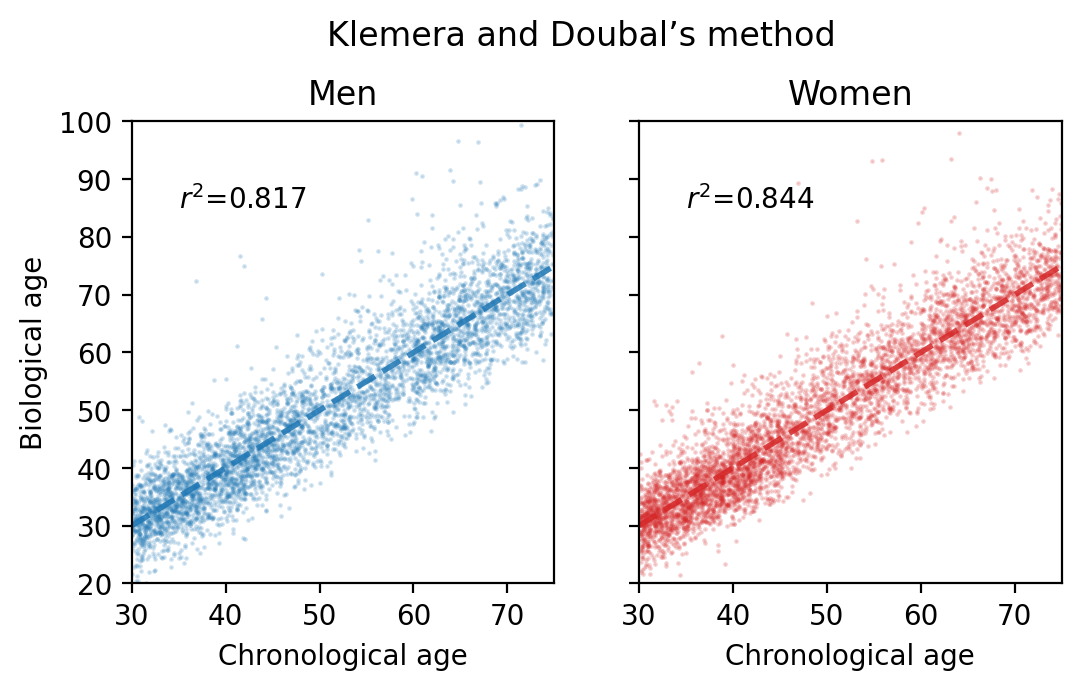

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), dpi=200, sharex=True, sharey=True)

for sex in [1, 2]:

    a, b = np.polyfit(df_norm[df_norm.HSSEX == sex].HSAGEIR, kl_mf[sex-1], deg=1)
    
    score = r2_score(df_norm[df_norm.HSSEX == sex].HSAGEIR, kl_mf[sex-1])
    
    axes[sex-1].scatter(df_norm[df_norm.HSSEX == sex].HSAGEIR, kl_mf[sex-1], s=0.5, alpha=.2, color={1:'tab:blue', 2:'tab:red'}[sex])
    
    axes[sex-1].plot(np.arange(30, 76), np.arange(30, 76)*a+b, alpha=.85, linewidth=2, 
                 linestyle='--', label='regression CA ~ BA', color={1:'tab:blue', 2:'tab:red'}[sex])
#     axes[sex-1].plot(np.arange(30, 76), np.arange(30, 76), alpha=.85, 
#                  color='tab:orange', label='curve x=y')
    axes[sex-1].text(35, 85, f'$r^2$={score:.3f}')

    axes[sex-1].set_ylim(20, 100)
    axes[sex-1].set_xlim(30, 75)

    axes[sex-1].set_xlabel('Chronological age')
    

axes[0].set_title('Men')
axes[1].set_title('Women')  
axes[0].set_ylabel('Biological age')

plt.suptitle('Klemera and Doubal’s method', y=1.05)

plt.show()

### Table 3

Because in my sample all 10 chosen variable significantly correlate with first components I didn't test models with 7 variables. Also, in the paper it is not clear how they defined significance of variable's investments in the first proncipal component. Note that in paper models based on 7 and 10 biomarkers do not show much difference.

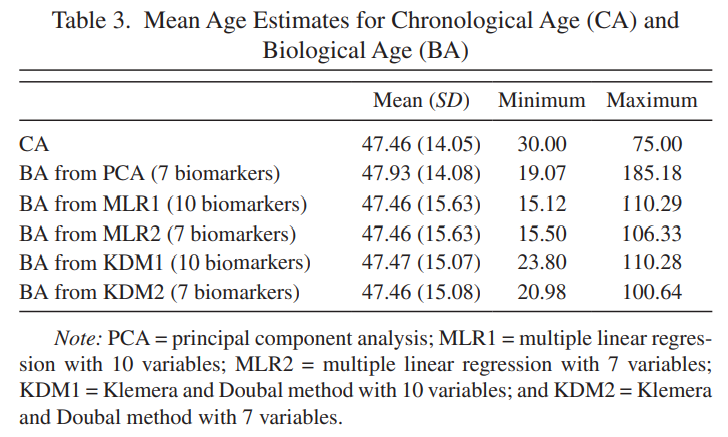

In [36]:
values = []
switch = True

values = []

for _mf in [df.HSAGEIR, pca_ba_mf, mlr_mf, kl_mf]:
    if not switch:
        _mf = np.concatenate(_mf)
        
    val = [
        f'{_mf.mean():.2f}, ({_mf.std():.2f})', 
        f'{_mf.min():2f}',
        f'{_mf.max():2f}'
    ]
    values.append(val)
    switch = False
    
indices = [
    'Chronological Age', 
    'Principal Component Analysis',
    'Multiple Linear Regression',
    'Klemera and Doubal’s method'
]

columns = ['Mean (std)', 'Minimum', 'Maximum']

table3 = pd.DataFrame(data=values, index=indices, columns=columns)

In [37]:
table3

,Mean (std),Minimum,Maximum
Chronological Age,"49.96, (13.34)",30.083333,74.916667
Principal Component Analysis,"49.96, (12.95)",18.199931,211.367337
Multiple Linear Regression,"49.96, (14.90)",14.347522,103.457585
Klemera and Doubal’s method,"49.96, (14.42)",17.852403,106.542431


# Bilogical Age estimates and mortality

PCA
Male ROC-AUC0.7756513331441603
Female ROC-AUC0.7957619904883738
MLR
Male ROC-AUC0.8463240724551694
Female ROC-AUC0.8517500443043062
KDM
Male ROC-AUC0.8549988964908408
Female ROC-AUC0.861173223219782


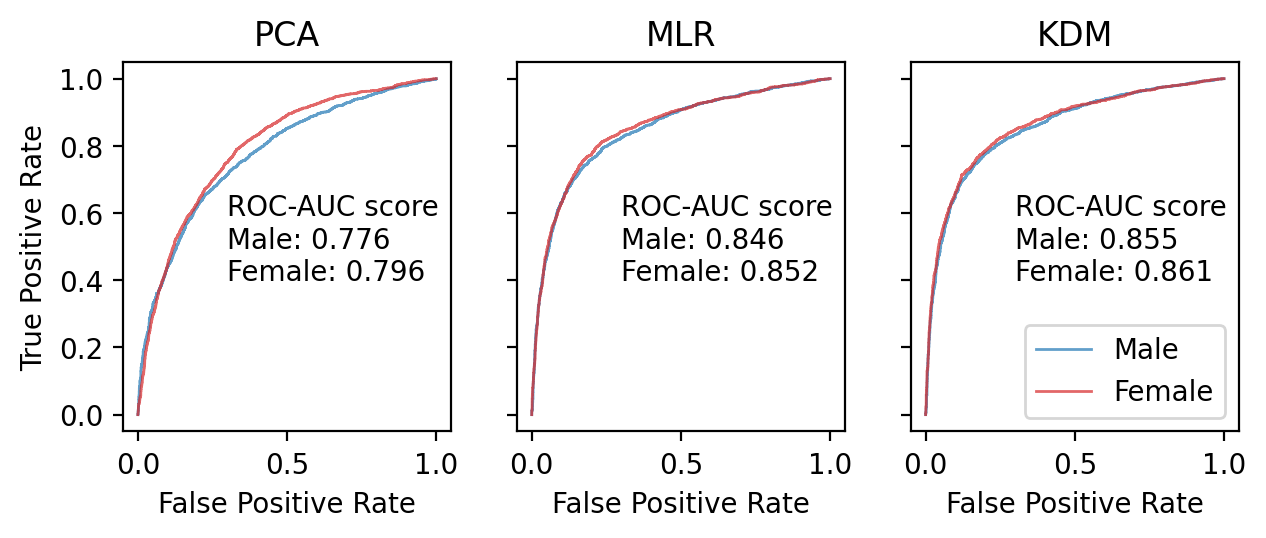

In [38]:
fig, axes = plt.subplots(ncols=3, figsize=(7.2, 2.4), dpi=200, sharex=True, sharey=True)

counter = 0

for _mf, name in zip([pca_ba_mf, mlr_mf, kl_mf], ['PCA', 'MLR', 'KDM']):
    
    print(name)
    rocaucs = []
    
    for sex in [1, 2]:

        Cox_train = pd.DataFrame({
            'MORTSTAT':df_norm[df_norm.HSSEX == sex].MORTSTAT,
            'PERMTH_EXM':df_norm[df_norm.HSSEX == sex].PERMTH_EXM,
            'BA':_mf[sex-1]
            })
        cph = CoxPHFitter()
        cph.fit(Cox_train, duration_col="PERMTH_EXM", event_col="MORTSTAT")

        res = cph.predict_cumulative_hazard(Cox_train) # predict_survival_function(Cox_train)
        res = np.array(res).T
        res = res[:, -1]
#         res = np.array([np.trapz(i) for i in res])
#         res = (res - res.min()) / (res.max() - res.min())

        fpr, tpr, _ = roc_curve(df_norm[df_norm.HSSEX == sex].MORTSTAT, res)

        axes[counter].plot(fpr, tpr, color={1:'tab:blue', 2:'tab:red'}[sex], 
                           alpha=0.7, linewidth=1, label={1:'Male', 2:'Female'}[sex])
        axes[counter].set_title(name)        
        axes[counter].set_xlabel('False Positive Rate')
        
        rocaucs.append(roc_auc_score(df_norm[df_norm.HSSEX == sex].MORTSTAT, res))
        print({1:'Male', 2:'Female'}[sex], 
              f'ROC-AUC{rocaucs[-1]}')
    
    axes[counter].text(0.3, 0.4, f'ROC-AUC score\nMale: {rocaucs[0]:.3f}\nFemale: {rocaucs[1]:.3f}')
    counter+=1
axes[-1].legend()    
axes[0].set_ylabel('True Positive Rate')
plt.show()

CA + PCA
Male ROC-AUC0.8523770351622922
Female ROC-AUC0.861812528709029
CA + MLR
Male ROC-AUC0.8520980527601583
Female ROC-AUC0.8571780884620611
CA + KDM
Male ROC-AUC0.8559396022207764
Female ROC-AUC0.8615071598663995


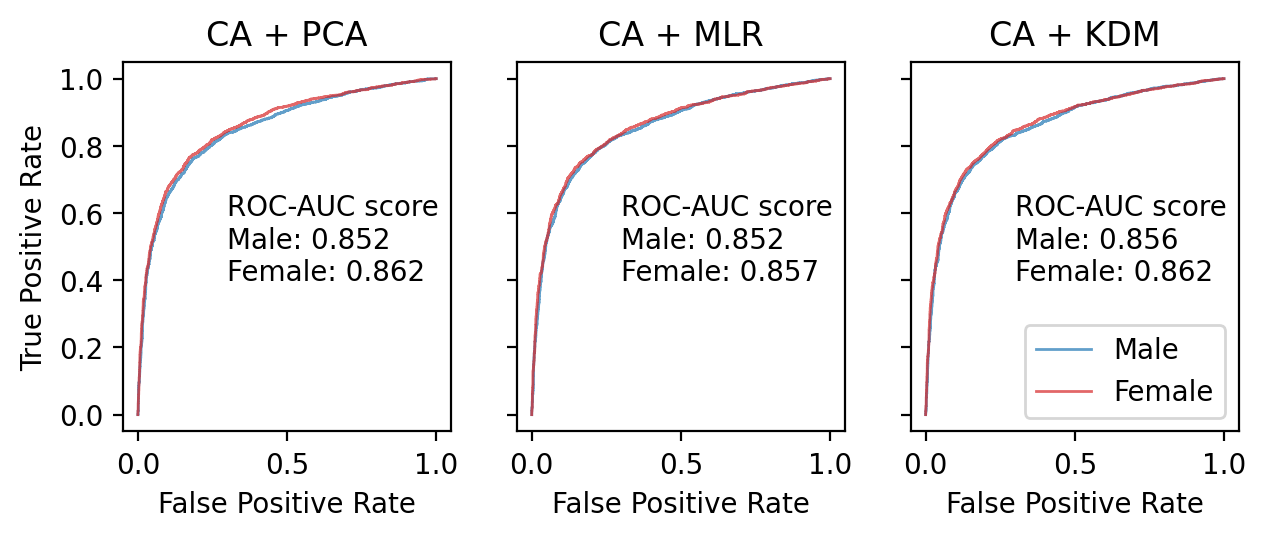

In [39]:
fig, axes = plt.subplots(ncols=3, figsize=(7.2, 2.4), dpi=200, sharex=True, sharey=True)

counter = 0

for _mf, name in zip([pca_ba_mf, mlr_mf, kl_mf], ['CA + PCA', 'CA + MLR', 'CA + KDM']):
    
    print(name)
    rocaucs = []
    
    for sex in [1, 2]:

        Cox_train = pd.DataFrame({
            'MORTSTAT':df_norm[df_norm.HSSEX == sex].MORTSTAT,
            'PERMTH_EXM':df_norm[df_norm.HSSEX == sex].PERMTH_EXM,
            'BA':_mf[sex-1],
            'CA':df_norm[df_norm.HSSEX == sex].HSAGEIR
            })
        cph = CoxPHFitter()
        cph.fit(Cox_train, duration_col="PERMTH_EXM", event_col="MORTSTAT")

        res = cph.predict_cumulative_hazard(Cox_train) # predict_survival_function(Cox_train)
        res = np.array(res).T
        res = res[:, -1]
#         res = np.array([np.trapz(i) for i in res])
#         res = (res - res.min()) / (res.max() - res.min())

        fpr, tpr, _ = roc_curve(df_norm[df_norm.HSSEX == sex].MORTSTAT, res)

        axes[counter].plot(fpr, tpr, color={1:'tab:blue', 2:'tab:red'}[sex], 
                           alpha=0.7, linewidth=1, label={1:'Male', 2:'Female'}[sex])
        axes[counter].set_title(name)        
        axes[counter].set_xlabel('False Positive Rate')
        
        rocaucs.append(roc_auc_score(df_norm[df_norm.HSSEX == sex].MORTSTAT, res))
        print({1:'Male', 2:'Female'}[sex], 
              f'ROC-AUC{rocaucs[-1]}')
    
    axes[counter].text(0.3, 0.4, f'ROC-AUC score\nMale: {rocaucs[0]:.3f}\nFemale: {rocaucs[1]:.3f}')
    counter+=1
axes[-1].legend()    
axes[0].set_ylabel('True Positive Rate')
plt.show()

Male ROC-AUC0.8436030386151773
Female ROC-AUC0.8466410072910846


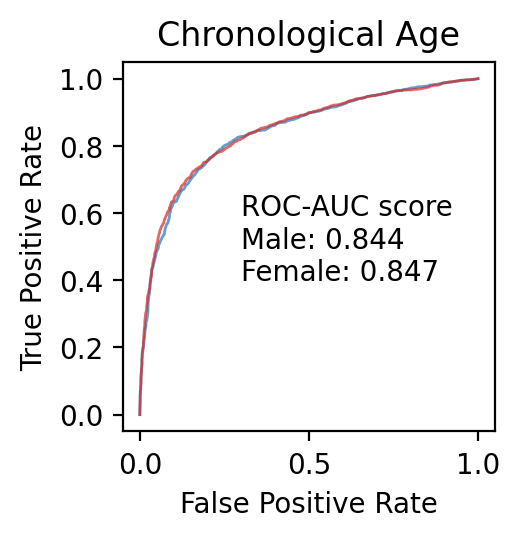

In [40]:
fig, axes = plt.subplots(figsize=(2.4, 2.4), dpi=200, sharex=True, sharey=True)

rocaucs = []

for sex in [1, 2]:

    Cox_train = pd.DataFrame({
        'MORTSTAT':df_norm[df_norm.HSSEX == sex].MORTSTAT,
        'PERMTH_EXM':df_norm[df_norm.HSSEX == sex].PERMTH_EXM,
        'CA':df_norm[df_norm.HSSEX == sex].HSAGEIR
        })
    cph = CoxPHFitter()
    cph.fit(Cox_train, duration_col="PERMTH_EXM", event_col="MORTSTAT")

    res = cph.predict_survival_function(Cox_train)
    res = np.array(res).T
    res = np.array([np.trapz(i) for i in res])
    res = 1 - (res - res.min()) / (res.max() - res.min())

    fpr, tpr, _ = roc_curve(df_norm[df_norm.HSSEX == sex].MORTSTAT, res)

    axes.plot(fpr, tpr, color={1:'tab:blue', 2:'tab:red'}[sex], 
                       alpha=0.7, linewidth=1, label={1:'Male', 2:'Female'}[sex])
          
    axes.set_xlabel('False Positive Rate')

    rocaucs.append(roc_auc_score(df_norm[df_norm.HSSEX == sex].MORTSTAT, res))
    print({1:'Male', 2:'Female'}[sex], 
          f'ROC-AUC{rocaucs[-1]}')

axes.text(0.3, 0.4, f'ROC-AUC score\nMale: {rocaucs[0]:.3f}\nFemale: {rocaucs[1]:.3f}')
axes.set_title('Chronological Age')  

axes.set_ylabel('True Positive Rate')

counter+=1

Both ROC-AUC0.8444237292108523


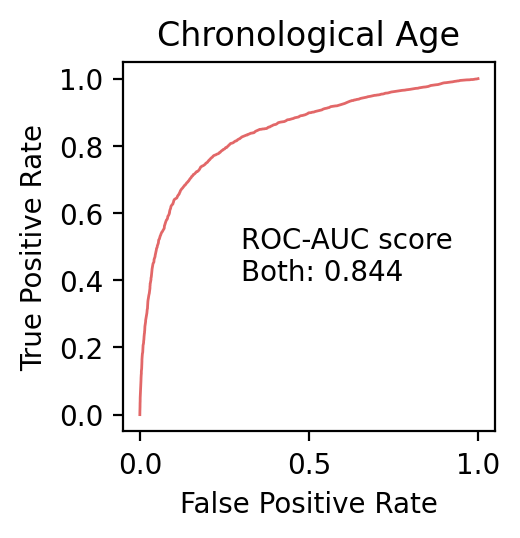

In [41]:
fig, axes = plt.subplots(figsize=(2.4, 2.4), dpi=200, sharex=True, sharey=True)

rocaucs = []

Cox_train = pd.DataFrame({
    'MORTSTAT':df_norm.MORTSTAT,
    'PERMTH_EXM':df_norm.PERMTH_EXM,
    'CA':df_norm.HSAGEIR
    })
cph = CoxPHFitter()
cph.fit(Cox_train, duration_col="PERMTH_EXM", event_col="MORTSTAT")

res = cph.predict_survival_function(Cox_train)
res = np.array(res).T
res = np.array([np.trapz(i) for i in res])
res = 1 - (res - res.min()) / (res.max() - res.min())

fpr, tpr, _ = roc_curve(df_norm.MORTSTAT, res)

axes.plot(fpr, tpr, color={1:'tab:blue', 2:'tab:red'}[sex], 
                   alpha=0.7, linewidth=1, label='both')

axes.set_xlabel('False Positive Rate')

rocaucs.append(roc_auc_score(df_norm.MORTSTAT, res))
print('Both', 
      f'ROC-AUC{rocaucs[-1]}')

axes.text(0.3, 0.4, f'ROC-AUC score\nBoth: {rocaucs[0]:.3f}')
axes.set_title('Chronological Age')  

axes.set_ylabel('True Positive Rate')

counter+=1

Both ROC-AUC0.8475533331654893


Text(0.5, 1.0, 'Chronological Age + Sex')

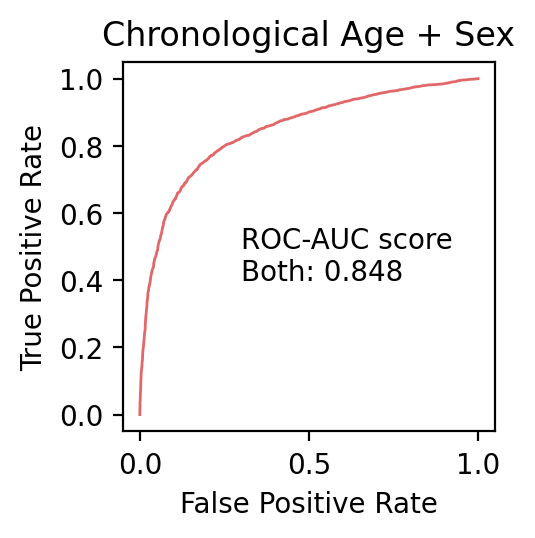

In [42]:
fig, axes = plt.subplots(figsize=(2.4, 2.4), dpi=200, sharex=True, sharey=True)

rocaucs = []

Cox_train = pd.DataFrame({
    'MORTSTAT':df_norm.MORTSTAT,
    'PERMTH_EXM':df_norm.PERMTH_EXM,
    'CA':df_norm.HSAGEIR,
    'HSSEX':df_norm.HSSEX,
    })
cph = CoxPHFitter()
cph.fit(Cox_train, duration_col="PERMTH_EXM", event_col="MORTSTAT")

res = cph.predict_survival_function(Cox_train)
res = np.array(res).T
res = np.array([np.trapz(i) for i in res])
res = 1 - (res - res.min()) / (res.max() - res.min())

fpr, tpr, _ = roc_curve(df_norm.MORTSTAT, res)

axes.plot(fpr, tpr, color={1:'tab:blue', 2:'tab:red'}[sex], 
                   alpha=0.7, linewidth=1, label='both')

axes.set_xlabel('False Positive Rate')

rocaucs.append(roc_auc_score(df_norm.MORTSTAT, res))
print('Both', 
      f'ROC-AUC{rocaucs[-1]}')

axes.text(0.3, 0.4, f'ROC-AUC score\nBoth: {rocaucs[0]:.3f}')
axes.set_ylabel('True Positive Rate')
axes.set_title('Chronological Age + Sex')  

# ROC-AUC stratified by age groups

In [43]:
age_group_masks = [
    (df.HSAGEIR > 30),
    (df.HSAGEIR > 30) & (df.HSAGEIR <= 59),
    (df.HSAGEIR >= 60) & (df.HSAGEIR < 75)
]

age_group_names = [
    f'Full sample',
    f'Aged 30–59 years',
    f'Aged 60–75 years'
]

indices = [
    'Chronological Age',
    'Principal Component Analysis',
    'Multiple linear regression',
    'Klemera and Doubal’s method'
]

all_rocaucs = []
all_summary = []

for _mf, name in zip([None, pca_ba_mf, mlr_mf, kl_mf], ['CA', 'CA + PCA', 'CA + MLR', 'CA + KDM']):
    
    print(name)
    rocaucs = []
    summary = []
    
    for mask in age_group_masks:

        if _mf == None:
            Cox_train = pd.DataFrame({
                'MORTSTAT':df_norm[mask].MORTSTAT,
                'PERMTH_EXM':df_norm[mask].PERMTH_EXM,
#                 'BA':pd.concat(_mf).sort_index()[mask],
                'CA':df_norm[mask].HSAGEIR,
                'SEX':df_norm[mask].HSSEX
                })
        else:
            Cox_train = pd.DataFrame({
                'MORTSTAT':df_norm[mask].MORTSTAT,
                'PERMTH_EXM':df_norm[mask].PERMTH_EXM,
                'BA':pd.concat(_mf).sort_index()[mask],
                'CA':df_norm[mask].HSAGEIR,
                'SEX':df_norm[mask].HSSEX
                })
            
        cph = CoxPHFitter()
        cph.fit(Cox_train, duration_col="PERMTH_EXM", event_col="MORTSTAT")

        res = cph.predict_cumulative_hazard(Cox_train) # predict_survival_function(Cox_train)
        res = np.array(res).T
        res = res[:, -1]

        rocaucs.append(roc_auc_score(df_norm[mask].MORTSTAT, res))
        
        summary.append(cph.summary)
        
    all_rocaucs.append(rocaucs)
    all_summary.append(summary)
    
table4 = pd.DataFrame(all_rocaucs, index=indices, columns=age_group_names)

all_summary = [i[0] for i in all_summary][1:]
all_summary = [i.loc[['CA', 'BA'], ['exp(coef)', 'se(coef)', 'p', 'exp(coef) lower 95%', 'exp(coef) upper 95%']] for i in all_summary]

CA
CA + PCA
CA + MLR
CA + KDM


### Table 4

I'm not quite sure which statistical test they used for comparisons of mortality predictions

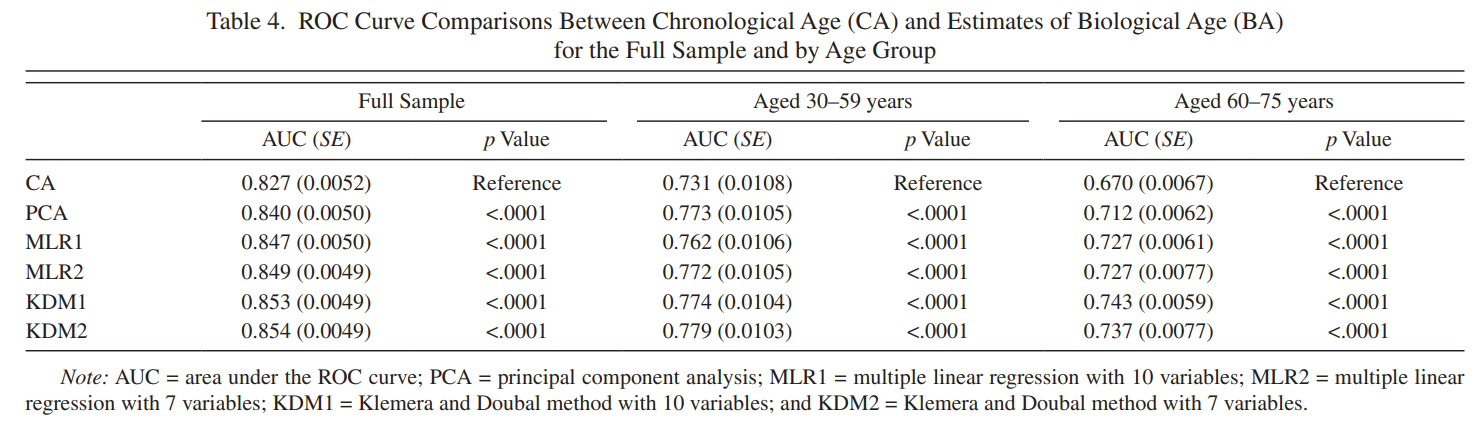

In [44]:
table4.round(3)

,Full sample,Aged 30–59 years,Aged 60–75 years
Chronological Age,0.848,0.719,0.703
Principal Component Analysis,0.859,0.750,0.726
Multiple linear regression,0.857,0.740,0.721
Klemera and Doubal’s method,0.861,0.751,0.729


### Table 5

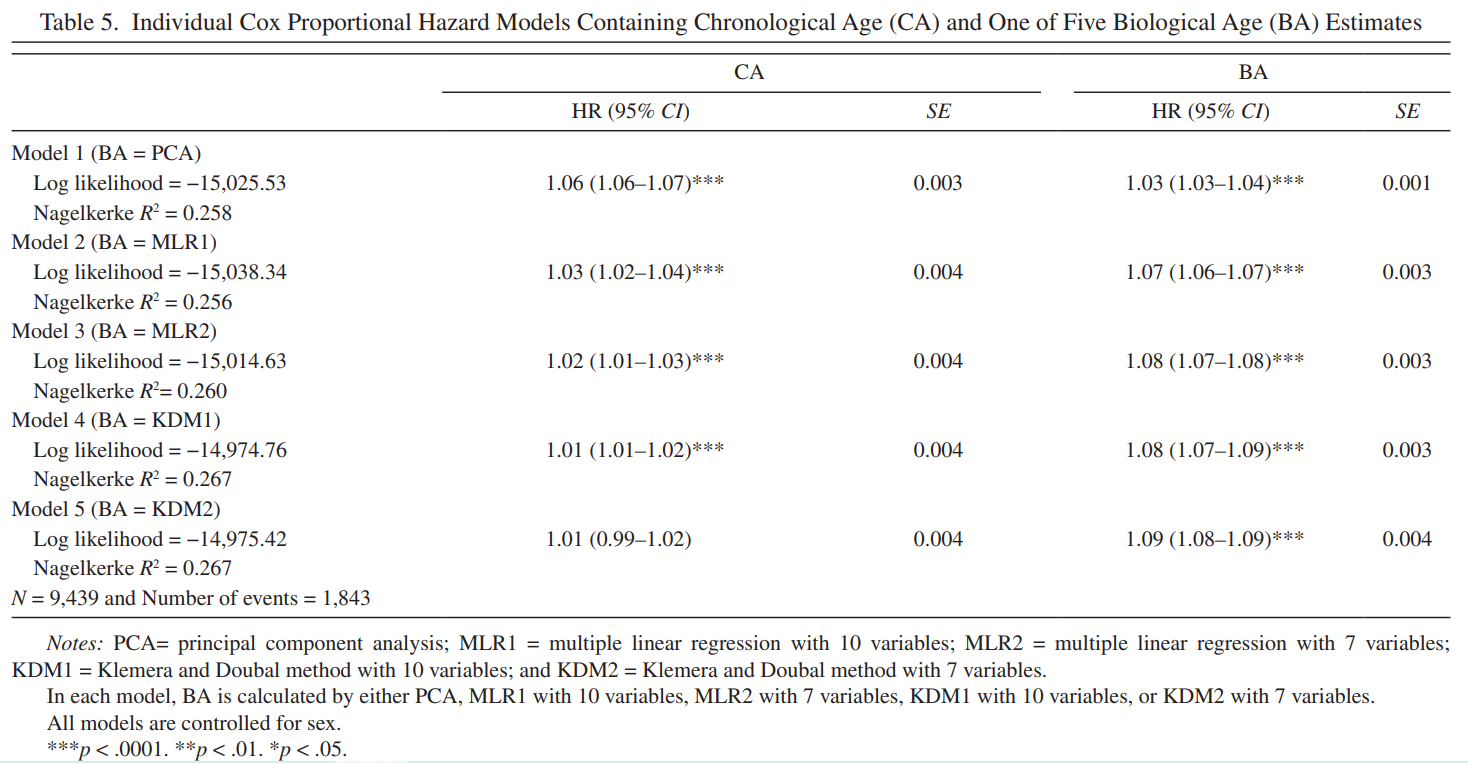

In [45]:
all_summary

[           exp(coef)  se(coef)              p  exp(coef) lower 95%  \
 covariate                                                            
 CA          1.079768  0.001501   0.000000e+00             1.076595   
 BA          1.025935  0.000918  4.226578e-171             1.024090   
 
            exp(coef) upper 95%  
 covariate                       
 CA                    1.082949  
 BA                    1.027783  ,
            exp(coef)  se(coef)              p  exp(coef) lower 95%  \
 covariate                                                            
 CA           1.04249  0.002535   1.570433e-60             1.037322   
 BA           1.05004  0.002184  1.101386e-110             1.045554   
 
            exp(coef) upper 95%  
 covariate                       
 CA                    1.047684  
 BA                    1.054545  ,
            exp(coef)  se(coef)              p  exp(coef) lower 95%  \
 covariate                                                            
 CA         

In [46]:
all_summary[0].loc['CA', 'exp(coef) lower 95%']

1.0765953754925461

In [47]:
indices = ['CA + PCA', 'CA + MLR', 'CA + KDM']
columns = ['CA HR (95% CI)', 'CA SE', 'BA HR (95% CI)', 'BA SE']

# all p-vals are very low, I'm adding '***' without a doubt
values = [
    [f"{i.round(2).loc['CA', 'exp(coef)']} ({i.round(2).loc['CA', 'exp(coef) lower 95%']}-{i.round(2).loc['CA', 'exp(coef) upper 95%']})***" for i in all_summary],
    [f"{i.round(3).loc['CA', 'se(coef)']}" for i in all_summary],
    [f"{i.round(2).loc['BA', 'exp(coef)']} ({i.round(2).loc['BA', 'exp(coef) lower 95%']}-{i.round(2).loc['BA', 'exp(coef) upper 95%']})***" for i in all_summary],
    [f"{i.round(3).loc['BA', 'se(coef)']}" for i in all_summary],

]

table5 = pd.DataFrame(values, columns=indices, index=columns).T

In [48]:
table5

,CA HR (95% CI),CA SE,BA HR (95% CI),BA SE
CA + PCA,1.08 (1.08-1.08)***,0.002,1.03 (1.02-1.03)***,0.001
CA + MLR,1.04 (1.04-1.05)***,0.003,1.05 (1.05-1.05)***,0.002
CA + KDM,1.03 (1.02-1.03)***,0.003,1.07 (1.06-1.07)***,0.002
